In [45]:
#!pip install optuna
import pandas as pd
import pickle
import datetime
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import matplotlib.pyplot as pit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import optuna.integration.lightgbm as lgb_o
import lightgbm as lgb

# exports
def plot_calibration_curve(named_classifiers, X_test, y_test):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="完全な補正")
    for name, clf in named_classifiers.items():
        prob_pos = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_pos)
        brier = brier_score_loss(y_test, prob_pos)
        print("%s:" % name)
        print("\tAUC  : %1.3f" % auc)
        print("\tBrier: %1.3f" % (brier))
        print()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test,
            prob_pos,
            n_bins=10,
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, brier),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("正例の比率")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("信頼性曲線")

    ax2.set_xlabel("予測値の平均")
    ax2.set_ylabel("サンプル数")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    
def build_data(base_name, new_name, result, vec):
    allrace = pd.read_pickle(base_name)
    df = allrace.reset_index()

    all_r = preprocessing(df)
    all_r['result'] = all_r['result'].map(lambda x: 1 if x < result else 0)

    categorical = process_categorical(all_r, [
        'producer', 'owner', 'training_course', 'course',
        'jockey_id', 'gender', 'trainer_id', 'weight',
        '天候', '馬場状態', 'place_id',
        'color_id', 'stallion_id', 'affiliation_id',
    ])

    categorical = categorical.reset_index()
    categorical = categorical.merge(vec, on='horse_id')
    categorical = categorical.set_index('race_id')

    train1, valid1 = split_data(categorical)
    valid1, test2 = train_valid_split_data(valid1)

    target = pd.read_pickle('./pickle_new/new_race_20221127_shinba.pickle')
    target = target[target['date'].notnull()]
    target = preprocessing(target)
    target['result'] = target['result'].map(lambda x: 1 if x < result else 0)

    test1 = process_categorical(target,  [
        'producer', 'owner', 'training_course', 'course',
        'jockey_id', 'gender', 'trainer_id', 'weight',
        '天候', '馬場状態', 'place_id',
        'color_id', 'stallion_id', 'affiliation_id',
    ])

    test1 = test1.reset_index()
    test1 = test1.merge(vec, on='horse_id')
    test1 = test1.set_index('race_id')

    X_train1 = train1.drop(['id', 'date', 'result',  'time_popular', 'time_odds', 'odds', 'popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_train1 = train1['result']
    X_valid1 = valid1.drop(['date', 'result', 'popular',  'time_popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_valid1 = valid1['result']
    X_test2 = test2.drop(['date', 'result', 'popular',  'time_popular', 'horse_id', 'owner', 'producer', '気温', '風速'], axis=1)
    y_test2 = test2['result']
    X_test1 = test1.drop(['date', 'result', 'popular', 'popular',  'time_popular', 'horse_id', 'owner', 'producer', '気温', '風速', '同周り複勝率', '同周り勝率', '同周り連対率'], axis=1)
    y_test1 = test1['result']
    
    return {
        'X_train': X_train1,
        'y_train': y_train1,
        'X_valid': X_valid1,
        'y_valid': y_valid1,
        'X_test2': X_test2,
        'y_test2': y_test2,
        'X_test1': X_test1,
        'y_test1': y_test1,
    }

def preprocessing(results, kako=5):
    df = results.copy()
    df.drop(['rank', 'body_weight',  'grade'], axis=1, inplace=True)
    df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    df = df.sort_values(by='date', ascending = False)
    df = df.set_index('race_id')
    return df

def split_data(df, test_size=0.3, place=None):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]

    train = df.loc[train_ids]
    test = df.loc[test_ids]
    
    return train, test

def train_valid_split_data(df, test_size=0.3):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
    
    train = df.loc[train_ids]
    valid = df.loc[test_ids]
    
    return train, valid

def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    # df2 = pd.get_dummies(df2, sparse=True)
    df2 = pd.get_dummies(df2)
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

def optuna_params(X_train, y_train, X_valid, y_valid):
    lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
    lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

    params = {
        'objective': 'binary',
        'random_state': 100
    }

    lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)
    
    return lgb_clf_o.params

def fit(params, X, y):
    lgb_clf = lgb.LGBMClassifier(**params)
    lgb_clf.fit(X.values, y.values)
    
    return lgb_clf

def tansho_return_rate(X, wr):
    wr['expected'] = wr['win_ratio'] * wr['time_odds'] 
    wr['pred_rank'] = wr[['win_ratio']].groupby('race_id').rank(ascending=False)
    
    race_grade = pd.read_csv('./csv_new2/races.csv')
    race_grade = race_grade.set_index('race_id')
    race_grade[['grade']]

    bets = wr.merge(race_grade, on='race_id')

    weather = pd.read_csv('./csv_new2/weathers.csv')
    bets = bets.merge(weather[['race_id', 'place_id']], on='race_id')

    # 賭ける馬
    v_bt = bets[
    #     (bets['pred_rank'] == 1)
    #     &
        (bets['expected'] >= 1)
    ]

    kaime = v_bt.merge(haitou[['1着馬番', '単勝']], on='race_id')
    
    print("点数：{} レース数:{} 対象レース率:{:.1%} 的中率:{:.1%} 的中数:{} 賭金:{:,}円 配当合計:{:,}円 最高配当:{:,}円 回収率:{:.1%}". format(
        len(kaime),\
        len(X.groupby('race_id')),\
        len(kaime.groupby('race_id')) / len(X.groupby('race_id')),\
        len(kaime[kaime['h_num'] == kaime['1着馬番']]) / (len(kaime)),\
        len(kaime[kaime['h_num'] == kaime['1着馬番']]),\
        len(kaime) * 100,\
        kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].sum(),\
        kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].max(),\
        (kaime[kaime['h_num'] == kaime['1着馬番']]['単勝'].sum() / (len(kaime) * 100))
    ))
    
def umaren_return_rate(fmrt, haitou):
    uma_haito = fmrt.merge(haitou[['1着馬番', '2着馬番', '馬連', '馬単']], left_index=True, right_index=True)

    f_bt = uma_haito[
        (
            (uma_haito['h_num_x'] == uma_haito['1着馬番'])
            &
            (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
        )
        |
        (
            (uma_haito['h_num_x'] == uma_haito['2着馬番'])
            &
            (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
        )
    ]


    print("点数：{} 的中数:{} 的中率:{:.1%}". format(
        len(uma_haito),\
        len(f_bt),\
        len(f_bt) / len(uma_haito)
    ))
    
    print("馬連賭金:{:,}円 馬連配当合計:{:,}円 馬連最高配当:{:,}円 馬連回収率:{:.1%}". format(
        (len(uma_haito) * 100),\
        f_bt['馬連'].sum(),\
        f_bt['馬連'].max(),\
        (f_bt['馬連'].sum() / (len(uma_haito) * 100))
    ))
    
    print("馬単賭金:{:,}円 馬単配当合計:{:,}円 馬単最高配当:{:,}円 馬単回収率:{:.1%}". format(
        (len(uma_haito) * 200),\
        f_bt['馬単'].sum(),\
        f_bt['馬単'].max(),\
        (f_bt['馬単'].sum() / (len(uma_haito) * 200))
    ))
    
def sanrenkei(kaime):
    f_b3 = kaime[
        ((kaime['h_num_x'] == kaime['1着馬番']) & (kaime['h_num_y'] == kaime['2着馬番']) & (kaime['h_num'] == kaime['3着馬番']))
        |
        ((kaime['h_num_x'] == kaime['1着馬番']) & (kaime['h_num_y'] == kaime['3着馬番']) & (kaime['h_num'] == kaime['2着馬番']))
        |
        ((kaime['h_num_x'] == kaime['2着馬番']) & (kaime['h_num_y'] == kaime['1着馬番']) & (kaime['h_num'] == kaime['3着馬番']))
        |
        ((kaime['h_num_x'] == kaime['2着馬番']) & (kaime['h_num_y'] == kaime['3着馬番']) & (kaime['h_num'] == kaime['1着馬番']))
        |
        ((kaime['h_num_x'] == kaime['3着馬番']) & (kaime['h_num_y'] == kaime['1着馬番']) & (kaime['h_num'] == kaime['2着馬番']))
        |
        ((kaime['h_num_x'] == kaime['3着馬番']) & (kaime['h_num_y'] == kaime['2着馬番']) & (kaime['h_num'] == kaime['1着馬番']))
    ]
    
    print("点数：{} 的中数:{} 的中率:{:.1%}". format(
        len(kaime),\
        len(f_b3),\
        len(f_b3) / len(kaime)
    ))

    print("3連複賭金:{:,}円 3連複配当合計:{:,}円 3連複最高配当:{:,}円 3連複回収率:{:.1%}". format(
        len(kaime) * 100,\
        f_b3['3連複'].sum(),\
        f_b3['3連複'].max(),\
         (f_b3['3連複'].sum() / (len(kaime) * 100))
    ))
    
    print("3連単賭金:{:,}円 3連単配当合計:{:,}円 3連単最高配当:{:,}円 3連単回収率:{:.1%}". format(
        len(kaime) * 600,\
        int(f_b3['3連単'].sum()),\
        int(f_b3['3連単'].max()),\
        (f_b3['3連単'].sum() / (len(kaime) * 600))
    ))
    
def wide_rate(kaime):
    s = kaime.reset_index()
    s = s[['race_id', 'h_num_x', 'h_num_y', 'h_num']]

    a = s[['race_id', 'h_num_x', 'h_num_y']]

    b = s[['race_id', 'h_num_y', 'h_num']]
    b['h_num_x'] = b['h_num_y']
    b['h_num_y'] = b['h_num']

    c = s[['race_id', 'h_num_x', 'h_num']]
    c['h_num_y'] = c['h_num']

    w = pd.concat([
        a[['race_id', 'h_num_x', 'h_num_y']],
        b[['race_id', 'h_num_x', 'h_num_y']],
        c[['race_id', 'h_num_x', 'h_num_y']],
    ]).drop_duplicates()
    wide = pd.read_csv('./csv_new2/base/wide.csv')
    w = w.merge(wide, on='race_id')
    
    wide = 0
    wide_tekichu = 0

    for i in range(1, 8):
        sm = str(i)
        w_b3 = w[
            (
                ((w['h_num_x'] == w['wide' + sm + '_uma1']) | (w['h_num_x'] == w['wide' + sm + '_uma2']))
                &
                ((w['h_num_y'] == w['wide' + sm + '_uma1']) | (w['h_num_y'] == w['wide' + sm + '_uma2']))
            )
        ]
        wide = wide + w_b3['wide_' + sm].sum()
        wide_tekichu = wide_tekichu + len(w_b3)

    print("ワイド点数：{} ワイド賭金:{:,}円 ワイド配当合計:{:,}円 ワイド的中数:{} ワイド的中率:{:.1%} ワイド回収率:{:.1%}". format(
        len(w),\
        len(w) * 100,\
        int(wide),\
        wide_tekichu,\
        wide_tekichu / len(w),\
        (wide / (len(w) * 100))
    ))

class TimeModel:
    def __init__(self, model, base_data):
        self.model = model
        self.base_data = base_data
        
    def pred_time(self, X):
        pred_time = self.base_data.copy()[['id', 'popular']]
        actual_table = X.copy()[['id', 'h_num', 'place_id']]

        X = X.drop(['id'], axis=1)
        actual_table['pred_time'] = model.predict(X)

        actual_table = actual_table.reset_index()
        pred_time = pred_time.reset_index()
        actual = pred_time.merge(actual_table, left_index=True, right_index=True, how='right')
        actual.drop(['id_x', 'id_y', 'race_id_y'], axis=1, inplace=True)

        return actual
    
    def race_pred_time(self, X):
        actual = self.pred_time(X)
        groups = actual.groupby('race_id_x').groups
        column_list = ["h_num", 'pred_time', 'popular']

        new_df = pd.DataFrame()
        max_length = 0
        for group, indexes in groups.items():
            # 最後に並び替えをさせるのに最大作成された項目数を記録
            length = len(indexes)+1
            if length > max_length:
                max_length = length

            columns = list()
            values = list()
            columns += ['race_id', 'place_id']
            values += [actual.iloc[indexes]['race_id_x'].T.tolist()[0], actual.iloc[indexes]['place_id'].T.tolist()[0]]

            for target_column in column_list:
                columns += [f'{target_column}_{x}' for x in range(1, length)]
                sort_values = actual.iloc[indexes, :].sort_values(by='pred_time', ascending = False)
                values += sort_values[target_column].T.tolist()

            record_df = pd.DataFrame([values], columns=columns)
            new_df = pd.concat([new_df, record_df], axis=0)

        return new_df

class ModelEvaluator:
    def __init__(self, model, haitou_table, std = True):
        self.model = model
        self.haitou = haitou_table
        self.std = std
        self.pp = None
        
    def predict_proba(self, X, std=True):
#         proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.pp is not None:
          return self.pp

        proba = pd.Series(self.model.predict_proba(X.drop(['id', 'odds', 'time_odds'], axis=1))[:, 1], index=X.index)
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
            
        self.pp = proba
        return proba
    
    def prefict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def proba(self, X):
        y_pred = self.predict_proba(X)
        return [p for p in y_pred]
    
    def win_ratio(self, X):
        sum1 = pd.DataFrame(self.predict_proba(X).groupby(level=0).sum())
        y_pred = self.predict_proba(X)

        return [(p / sum1.loc[i])[0] for i, p in y_pred.items()]
    
    def score(self, y_true, X):
        proba = self.predict_proba(X, True)
        n = lambda x: 0.0 if np.isnan(x) else x
        proba = proba.map(n)
        return roc_auc_score(y_true, proba)
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['h_num', 'odds', 'time_odds']]
        pred_table['pred'] = self.prefict(X, threshold)
        pred_table['win_ratio'] = self.win_ratio(X)
        pred_table['proba'] = self.proba(X)
        if bet_only:
            pred_table = pred_table[pred_table['pred'] == 1][['h_num', 'odds', 'time_odds', 'win_ratio', 'proba']]
            return pred_table
        else:
            return pred_table[['h_num', 'odds', 'time_odds', 'win_ratio', 'proba']]
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        haitou = self.haitou.copy()
        df = haitou.merge(pred_table, left_index=True, right_index=True, how='right')

        n_hits = len(df[df['1着馬番'] == df['h_num']]) + len(df[df['2着馬番'] == df['h_num']]) + len(df[df['3着馬番'] == df['h_num']]) + len(df[df['4着馬番'] == df['h_num']])
        for i in range(1, 5):
            money += df[df[str(i) + '着馬番'] == df['h_num']]['複勝' + str(i)].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate,n_hits
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        df['単勝配当'] = df['単勝'].astype(int)
        
        std = ((df['1着馬番'] ==  df['h_num']) * df['単勝配当'])\
        .groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['1着馬番'] == df['h_num']])
        
        money += df[df['1着馬番'] == df['h_num']]['単勝配当'].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        bet_money = (1/pred_table['odds']).sum()
        std = ((df['1着馬番'] == df['h_num']).astype(int)).groupby(level=0).sum().std() * np.sqrt(n_races) / bet_money
        
        df['h_num'] = df['h_num'].astype(float)
        df['馬番_1'] = df['1着馬番']
        n_hits = len(df.query('馬番_1 == h_num'))
        return_rate = n_hits/bet_money
        return n_bets, return_rate, n_hits
    
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i /n_samples + min_threshold * (1 - i/n_samples)
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets == 0:
            break;
        if n_bets > lower:
            gain[n_bets] = { 'return_rate': return_rate, 'n_hits': n_hits }
    return pd.DataFrame(gain).T

In [46]:
haitou = pd.read_csv('./csv_new2/race_detail.csv')
wide = pd.read_csv('./csv_new2/base/wide.csv')

haitou = haitou.merge(wide, on='race_id')
haitou = haitou.set_index('race_id')

shisuu = pd.read_csv('./shisuu_new.csv')

vec = pd.read_pickle('./pickle_new/peds_vec.pickle')
# vec = vec[[
#     'horse_id', "peds_2","peds_3","peds_4","peds_5",
#     "peds_6","peds_7","peds_8","peds_9","peds_10",
#     "peds_11","peds_12","peds_13","peds_14"
# ]]
vec.drop(['peds_1'], axis=1, inplace=True)

places = { 1: "札幌", 2: "函館", 3: "福島", 4: "新潟", 5: "東京", 6: "中山", 7: "中京", 8: "京都", 9: "阪神", 10: "小倉" }

In [47]:
d = build_data('./pickle_new/shinba_base.pickle', './pickle_new/peds_vec.pickle', 2, vec)
X_train1 = d['X_train']
y_train1 = d['y_train']
X_valid1 = d['X_valid']
y_valid1 = d['y_valid']
X_test2 = d['X_test2']
y_test2 = d['y_test2']
X_test1 = d['X_test1']
y_test1 = d['y_test1']

In [710]:
optuna_params(X_train1, y_train1, X_valid1, y_valid1)

[I 2022-10-27 09:13:36,521] A new study created in memory with name: no-name-c898289a-7679-4cd8-b965-9cc92af273dd


  0%|                                                                                                              | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.250120:   0%|                                                                       | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 0.250120:  14%|#########                                                      | 1/7 [00:01<00:07,  1.30s/it][I 2022-10-27 09:13:37,827] Trial 0 finished with value: 0.25011965619103793 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.25011965619103793.


feature_fraction, val_score: 0.250120:  14%|#########                                                      | 1/7 [00:01<00:07,  1.30s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.221156	valid_1's binary_logloss: 0.25012
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.248267:  14%|#########                                                      | 1/7 [00:02<00:07,  1.30s/it]

feature_fraction, val_score: 0.248267:  29%|##################                                             | 2/7 [00:02<00:06,  1.22s/it][I 2022-10-27 09:13:38,985] Trial 1 finished with value: 0.24826662790468854 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.24826662790468854.


feature_fraction, val_score: 0.248267:  29%|##################                                             | 2/7 [00:02<00:06,  1.22s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.224354	valid_1's binary_logloss: 0.248267
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.248267:  29%|##################                                             | 2/7 [00:03<00:06,  1.22s/it]

feature_fraction, val_score: 0.248267:  43%|###########################                                    | 3/7 [00:03<00:04,  1.17s/it][I 2022-10-27 09:13:40,104] Trial 2 finished with value: 0.24906493922583156 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.24826662790468854.


feature_fraction, val_score: 0.248267:  43%|###########################                                    | 3/7 [00:03<00:04,  1.17s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.214002	valid_1's binary_logloss: 0.249065
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.247001:  43%|###########################                                    | 3/7 [00:04<00:04,  1.17s/it]

feature_fraction, val_score: 0.247001:  57%|####################################                           | 4/7 [00:04<00:03,  1.16s/it][I 2022-10-27 09:13:41,259] Trial 3 finished with value: 0.24700070705646254 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.24700070705646254.


feature_fraction, val_score: 0.247001:  57%|####################################                           | 4/7 [00:04<00:03,  1.16s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.22209	valid_1's binary_logloss: 0.247001
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.247001:  57%|####################################                           | 4/7 [00:05<00:03,  1.16s/it]

feature_fraction, val_score: 0.247001:  71%|#############################################                  | 5/7 [00:05<00:02,  1.18s/it][I 2022-10-27 09:13:42,466] Trial 4 finished with value: 0.2496542810553598 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.24700070705646254.


feature_fraction, val_score: 0.247001:  71%|#############################################                  | 5/7 [00:05<00:02,  1.18s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.217519	valid_1's binary_logloss: 0.249654
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.247001:  71%|#############################################                  | 5/7 [00:06<00:02,  1.18s/it]

feature_fraction, val_score: 0.247001:  86%|######################################################         | 6/7 [00:06<00:01,  1.09s/it][I 2022-10-27 09:13:43,388] Trial 5 finished with value: 0.24947249028837692 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.24700070705646254.


feature_fraction, val_score: 0.247001:  86%|######################################################         | 6/7 [00:06<00:01,  1.09s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.232717	valid_1's binary_logloss: 0.249472
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.247001:  86%|######################################################         | 6/7 [00:07<00:01,  1.09s/it]

feature_fraction, val_score: 0.247001: 100%|###############################################################| 7/7 [00:07<00:00,  1.13s/it]


Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.232909	valid_1's binary_logloss: 0.254298




  0%|                                                                                                             | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.247001:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:   0%|                                                                            | 0/20 [00:01<?, ?it/s]

num_leaves, val_score: 0.247001:   5%|###4                                                                | 1/20 [00:01<00:25,  1.32s/it][I 2022-10-27 09:13:45,792] Trial 7 finished with value: 0.25329397590693836 and parameters: {'num_leaves': 52}. Best is trial 7 with value: 0.25329397590693836.


num_leaves, val_score: 0.247001:   5%|###4                                                                | 1/20 [00:01<00:25,  1.32s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.204637	valid_1's binary_logloss: 0.253294
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:   5%|###4                                                                | 1/20 [00:02<00:25,  1.32s/it]

num_leaves, val_score: 0.247001:  10%|######8                                                             | 2/20 [00:02<00:26,  1.45s/it][I 2022-10-27 09:13:47,327] Trial 8 finished with value: 0.2517310408807687 and parameters: {'num_leaves': 139}. Best is trial 8 with value: 0.2517310408807687.


num_leaves, val_score: 0.247001:  10%|######8                                                             | 2/20 [00:02<00:26,  1.45s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.192779	valid_1's binary_logloss: 0.251731
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  10%|######8                                                             | 2/20 [00:04<00:26,  1.45s/it]

num_leaves, val_score: 0.247001:  15%|##########2                                                         | 3/20 [00:04<00:24,  1.47s/it][I 2022-10-27 09:13:48,813] Trial 9 finished with value: 0.2541258604856643 and parameters: {'num_leaves': 100}. Best is trial 8 with value: 0.2517310408807687.


num_leaves, val_score: 0.247001:  15%|##########2                                                         | 3/20 [00:04<00:24,  1.47s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.192599	valid_1's binary_logloss: 0.254126
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  15%|##########2                                                         | 3/20 [00:05<00:24,  1.47s/it]

num_leaves, val_score: 0.247001:  20%|#############6                                                      | 4/20 [00:05<00:21,  1.31s/it][I 2022-10-27 09:13:49,896] Trial 10 finished with value: 0.24800320804002793 and parameters: {'num_leaves': 17}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  20%|#############6                                                      | 4/20 [00:05<00:21,  1.31s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.229687	valid_1's binary_logloss: 0.248003
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  20%|#############6                                                      | 4/20 [00:07<00:21,  1.31s/it]

num_leaves, val_score: 0.247001:  25%|#################                                                   | 5/20 [00:07<00:22,  1.48s/it][I 2022-10-27 09:13:51,673] Trial 11 finished with value: 0.2509398706164269 and parameters: {'num_leaves': 190}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  25%|#################                                                   | 5/20 [00:07<00:22,  1.48s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.186051	valid_1's binary_logloss: 0.25094
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  25%|#################                                                   | 5/20 [00:08<00:22,  1.48s/it]

num_leaves, val_score: 0.247001:  30%|####################4                                               | 6/20 [00:08<00:20,  1.46s/it][I 2022-10-27 09:13:53,107] Trial 12 finished with value: 0.2529295150581427 and parameters: {'num_leaves': 113}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  30%|####################4                                               | 6/20 [00:08<00:20,  1.46s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.210209	valid_1's binary_logloss: 0.25293
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  30%|####################4                                               | 6/20 [00:10<00:20,  1.46s/it]

num_leaves, val_score: 0.247001:  35%|#######################7                                            | 7/20 [00:10<00:20,  1.61s/it][I 2022-10-27 09:13:55,019] Trial 13 finished with value: 0.25264838893532565 and parameters: {'num_leaves': 146}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  35%|#######################7                                            | 7/20 [00:10<00:20,  1.61s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.159882	valid_1's binary_logloss: 0.252648
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  35%|#######################7                                            | 7/20 [00:12<00:20,  1.61s/it]

num_leaves, val_score: 0.247001:  40%|###########################2                                        | 8/20 [00:12<00:19,  1.64s/it][I 2022-10-27 09:13:56,718] Trial 14 finished with value: 0.2519433630270067 and parameters: {'num_leaves': 180}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  40%|###########################2                                        | 8/20 [00:12<00:19,  1.64s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.182705	valid_1's binary_logloss: 0.251943
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  40%|###########################2                                        | 8/20 [00:13<00:19,  1.64s/it]

num_leaves, val_score: 0.247001:  45%|##############################6                                     | 9/20 [00:13<00:17,  1.57s/it][I 2022-10-27 09:13:58,133] Trial 15 finished with value: 0.25422343866003166 and parameters: {'num_leaves': 125}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  45%|##############################6                                     | 9/20 [00:13<00:17,  1.57s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.207073	valid_1's binary_logloss: 0.254223
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  45%|##############################6                                     | 9/20 [00:15<00:17,  1.57s/it]

num_leaves, val_score: 0.247001:  50%|#################################5                                 | 10/20 [00:15<00:16,  1.63s/it][I 2022-10-27 09:13:59,899] Trial 16 finished with value: 0.25340432684947956 and parameters: {'num_leaves': 240}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  50%|#################################5                                 | 10/20 [00:15<00:16,  1.63s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.190988	valid_1's binary_logloss: 0.253404
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  50%|#################################5                                 | 10/20 [00:16<00:16,  1.63s/it]

num_leaves, val_score: 0.247001:  55%|####################################8                              | 11/20 [00:16<00:13,  1.49s/it][I 2022-10-27 09:14:01,066] Trial 17 finished with value: 0.24917734810307768 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  55%|####################################8                              | 11/20 [00:16<00:13,  1.49s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.224856	valid_1's binary_logloss: 0.249177
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  55%|####################################8                              | 11/20 [00:17<00:13,  1.49s/it]

num_leaves, val_score: 0.247001:  60%|########################################1                          | 12/20 [00:17<00:10,  1.34s/it][I 2022-10-27 09:14:02,079] Trial 18 finished with value: 0.24809635374890499 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  60%|########################################1                          | 12/20 [00:17<00:10,  1.34s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.235317	valid_1's binary_logloss: 0.248096
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  60%|########################################1                          | 12/20 [00:18<00:10,  1.34s/it]

num_leaves, val_score: 0.247001:  65%|###########################################5                       | 13/20 [00:18<00:09,  1.33s/it][I 2022-10-27 09:14:03,371] Trial 19 finished with value: 0.2496990830327145 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  65%|###########################################5                       | 13/20 [00:18<00:09,  1.33s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.230177	valid_1's binary_logloss: 0.249699
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  65%|###########################################5                       | 13/20 [00:20<00:09,  1.33s/it]

num_leaves, val_score: 0.247001:  70%|##############################################9                    | 14/20 [00:20<00:08,  1.37s/it][I 2022-10-27 09:14:04,834] Trial 20 finished with value: 0.2502118555514578 and parameters: {'num_leaves': 59}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  70%|##############################################9                    | 14/20 [00:20<00:08,  1.37s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.198146	valid_1's binary_logloss: 0.250212
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  70%|##############################################9                    | 14/20 [00:21<00:08,  1.37s/it]

num_leaves, val_score: 0.247001:  75%|##################################################2                | 15/20 [00:21<00:06,  1.38s/it][I 2022-10-27 09:14:06,234] Trial 21 finished with value: 0.25329397590693836 and parameters: {'num_leaves': 52}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  75%|##################################################2                | 15/20 [00:21<00:06,  1.38s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.204637	valid_1's binary_logloss: 0.253294
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  75%|##################################################2                | 15/20 [00:23<00:06,  1.38s/it]

num_leaves, val_score: 0.247001:  80%|#####################################################6             | 16/20 [00:23<00:05,  1.37s/it][I 2022-10-27 09:14:07,582] Trial 22 finished with value: 0.25495522143016824 and parameters: {'num_leaves': 81}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  80%|#####################################################6             | 16/20 [00:23<00:05,  1.37s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.203543	valid_1's binary_logloss: 0.254955
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.247001:  80%|#####################################################6             | 16/20 [00:24<00:05,  1.37s/it]

num_leaves, val_score: 0.247001:  85%|########################################################9          | 17/20 [00:24<00:03,  1.30s/it][I 2022-10-27 09:14:08,735] Trial 23 finished with value: 0.25091996025541885 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.24800320804002793.


num_leaves, val_score: 0.247001:  85%|########################################################9          | 17/20 [00:24<00:03,  1.30s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.222415	valid_1's binary_logloss: 0.25092
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.246894:  85%|########################################################9          | 17/20 [00:25<00:03,  1.30s/it]

num_leaves, val_score: 0.246894:  90%|############################################################3      | 18/20 [00:25<00:02,  1.29s/it][I 2022-10-27 09:14:09,993] Trial 24 finished with value: 0.2468940792820915 and parameters: {'num_leaves': 36}. Best is trial 24 with value: 0.2468940792820915.


num_leaves, val_score: 0.246894:  90%|############################################################3      | 18/20 [00:25<00:02,  1.29s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.21151	valid_1's binary_logloss: 0.246894
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.246894:  90%|############################################################3      | 18/20 [00:26<00:02,  1.29s/it]

num_leaves, val_score: 0.246894:  95%|###############################################################6   | 19/20 [00:27<00:01,  1.35s/it][I 2022-10-27 09:14:11,474] Trial 25 finished with value: 0.2536871911279751 and parameters: {'num_leaves': 78}. Best is trial 24 with value: 0.2468940792820915.


num_leaves, val_score: 0.246894:  95%|###############################################################6   | 19/20 [00:27<00:01,  1.35s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.192352	valid_1's binary_logloss: 0.253687
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.246894:  95%|###############################################################6   | 19/20 [00:28<00:01,  1.35s/it]

num_leaves, val_score: 0.246894: 100%|###################################################################| 20/20 [00:28<00:00,  1.44s/it]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.221578	valid_1's binary_logloss: 0.249267




  0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.246894:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.246894:   0%|                                                                               | 0/10 [00:01<?, ?it/s]

bagging, val_score: 0.246894:  10%|#######1                                                               | 1/10 [00:01<00:09,  1.01s/it][I 2022-10-27 09:14:14,201] Trial 27 finished with value: 0.24902473205135048 and parameters: {'bagging_fraction': 0.444386203237662, 'bagging_freq': 3}. Best is trial 27 with value: 0.24902473205135048.


bagging, val_score: 0.246894:  10%|#######1                                                               | 1/10 [00:01<00:09,  1.01s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.241346	valid_1's binary_logloss: 0.249025
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.246894:  10%|#######1                                                               | 1/10 [00:02<00:09,  1.01s/it]

bagging, val_score: 0.246894:  20%|##############2                                                        | 2/10 [00:02<00:09,  1.17s/it][I 2022-10-27 09:14:15,486] Trial 28 finished with value: 0.25371235229073297 and parameters: {'bagging_fraction': 0.8125833715230513, 'bagging_freq': 5}. Best is trial 27 with value: 0.24902473205135048.


bagging, val_score: 0.246894:  20%|##############2                                                        | 2/10 [00:02<00:09,  1.17s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.222415	valid_1's binary_logloss: 0.253712
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.246894:  20%|##############2                                                        | 2/10 [00:03<00:09,  1.17s/it]

bagging, val_score: 0.246894:  30%|#####################3                                                 | 3/10 [00:03<00:07,  1.13s/it][I 2022-10-27 09:14:16,564] Trial 29 finished with value: 0.24887188237135596 and parameters: {'bagging_fraction': 0.4603584783787247, 'bagging_freq': 5}. Best is trial 29 with value: 0.24887188237135596.


bagging, val_score: 0.246894:  30%|#####################3                                                 | 3/10 [00:03<00:07,  1.13s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.222622	valid_1's binary_logloss: 0.248872
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.246232:  30%|#####################3                                                 | 3/10 [00:04<00:07,  1.13s/it]

bagging, val_score: 0.246232:  40%|############################4                                          | 4/10 [00:04<00:07,  1.29s/it][I 2022-10-27 09:14:18,096] Trial 30 finished with value: 0.24623192103282796 and parameters: {'bagging_fraction': 0.7308511163984397, 'bagging_freq': 5}. Best is trial 30 with value: 0.24623192103282796.


bagging, val_score: 0.246232:  40%|############################4                                          | 4/10 [00:04<00:07,  1.29s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.210193	valid_1's binary_logloss: 0.246232
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.246232:  40%|############################4                                          | 4/10 [00:06<00:07,  1.29s/it]

bagging, val_score: 0.246232:  50%|###################################5                                   | 5/10 [00:06<00:07,  1.55s/it][I 2022-10-27 09:14:20,130] Trial 31 finished with value: 0.2509334914296106 and parameters: {'bagging_fraction': 0.867493795520367, 'bagging_freq': 1}. Best is trial 30 with value: 0.24623192103282796.


bagging, val_score: 0.246232:  50%|###################################5                                   | 5/10 [00:06<00:07,  1.55s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.226471	valid_1's binary_logloss: 0.250933
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.244718:  50%|###################################5                                   | 5/10 [00:08<00:07,  1.55s/it]

bagging, val_score: 0.244718:  60%|##########################################6                            | 6/10 [00:08<00:06,  1.50s/it][I 2022-10-27 09:14:21,528] Trial 32 finished with value: 0.2447177160914369 and parameters: {'bagging_fraction': 0.5609926769577654, 'bagging_freq': 5}. Best is trial 32 with value: 0.2447177160914369.


bagging, val_score: 0.244718:  60%|##########################################6                            | 6/10 [00:08<00:06,  1.50s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.219823	valid_1's binary_logloss: 0.244718
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.244718:  60%|##########################################6                            | 6/10 [00:09<00:06,  1.50s/it]

bagging, val_score: 0.244718:  70%|#################################################6                     | 7/10 [00:09<00:04,  1.42s/it][I 2022-10-27 09:14:22,758] Trial 33 finished with value: 0.25219629015156486 and parameters: {'bagging_fraction': 0.7667412683881585, 'bagging_freq': 7}. Best is trial 32 with value: 0.2447177160914369.


bagging, val_score: 0.244718:  70%|#################################################6                     | 7/10 [00:09<00:04,  1.42s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.223146	valid_1's binary_logloss: 0.252196
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.244718:  70%|#################################################6                     | 7/10 [00:10<00:04,  1.42s/it]

bagging, val_score: 0.244718:  80%|########################################################8              | 8/10 [00:10<00:02,  1.36s/it][I 2022-10-27 09:14:24,007] Trial 34 finished with value: 0.255853449243965 and parameters: {'bagging_fraction': 0.9003548600671125, 'bagging_freq': 7}. Best is trial 32 with value: 0.2447177160914369.


bagging, val_score: 0.244718:  80%|########################################################8              | 8/10 [00:10<00:02,  1.36s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.229059	valid_1's binary_logloss: 0.255853
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.243671:  80%|########################################################8              | 8/10 [00:13<00:02,  1.36s/it]

bagging, val_score: 0.243671:  90%|###############################################################9       | 9/10 [00:13<00:01,  1.87s/it][I 2022-10-27 09:14:27,007] Trial 35 finished with value: 0.24367120870518627 and parameters: {'bagging_fraction': 0.5122235475816761, 'bagging_freq': 3}. Best is trial 35 with value: 0.24367120870518627.


bagging, val_score: 0.243671:  90%|###############################################################9       | 9/10 [00:13<00:01,  1.87s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.216685	valid_1's binary_logloss: 0.243671
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.243671:  90%|###############################################################9       | 9/10 [00:15<00:01,  1.87s/it]

bagging, val_score: 0.243671: 100%|######################################################################| 10/10 [00:15<00:00,  1.57s/it]


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.198028	valid_1's binary_logloss: 0.24421




  0%|                                                                                                              | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.243671:   0%|                                                                | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.243671:   0%|                                                                | 0/6 [00:01<?, ?it/s]

feature_fraction_stage2, val_score: 0.243671:  17%|#########3                                              | 1/6 [00:01<00:06,  1.37s/it][I 2022-10-27 09:14:30,245] Trial 37 finished with value: 0.24427897045037558 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.24427897045037558.


feature_fraction_stage2, val_score: 0.243671:  17%|#########3                                              | 1/6 [00:01<00:06,  1.37s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.216949	valid_1's binary_logloss: 0.244279
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.242600:  17%|#########3                                              | 1/6 [00:02<00:06,  1.37s/it]

feature_fraction_stage2, val_score: 0.242600:  33%|##################6                                     | 2/6 [00:02<00:05,  1.44s/it][I 2022-10-27 09:14:31,728] Trial 38 finished with value: 0.24260023988931018 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.24260023988931018.


feature_fraction_stage2, val_score: 0.242600:  33%|##################6                                     | 2/6 [00:02<00:05,  1.44s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.213835	valid_1's binary_logloss: 0.2426
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.242600:  33%|##################6                                     | 2/6 [00:04<00:05,  1.44s/it]

feature_fraction_stage2, val_score: 0.242600:  50%|############################                            | 3/6 [00:04<00:04,  1.60s/it][I 2022-10-27 09:14:33,533] Trial 39 finished with value: 0.24396890270309388 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.24260023988931018.


feature_fraction_stage2, val_score: 0.242600:  50%|############################                            | 3/6 [00:04<00:04,  1.60s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.22076	valid_1's binary_logloss: 0.243969
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.242600:  50%|############################                            | 3/6 [00:05<00:04,  1.60s/it]

feature_fraction_stage2, val_score: 0.242600:  67%|#####################################3                  | 4/6 [00:05<00:02,  1.46s/it][I 2022-10-27 09:14:34,760] Trial 40 finished with value: 0.24603532859275537 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 0.24260023988931018.


feature_fraction_stage2, val_score: 0.242600:  67%|#####################################3                  | 4/6 [00:05<00:02,  1.46s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.216296	valid_1's binary_logloss: 0.246035
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.242600:  67%|#####################################3                  | 4/6 [00:07<00:02,  1.46s/it]

feature_fraction_stage2, val_score: 0.242600:  83%|##############################################6         | 5/6 [00:07<00:01,  1.49s/it][I 2022-10-27 09:14:36,312] Trial 41 finished with value: 0.24886991126089117 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 0.24260023988931018.


feature_fraction_stage2, val_score: 0.242600:  83%|##############################################6         | 5/6 [00:07<00:01,  1.49s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.214688	valid_1's binary_logloss: 0.24887
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.242600:  83%|##############################################6         | 5/6 [00:09<00:01,  1.49s/it]

feature_fraction_stage2, val_score: 0.242600: 100%|########################################################| 6/6 [00:09<00:00,  1.66s/it]


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.216018	valid_1's binary_logloss: 0.249091




  0%|                                                                                                             | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.242600:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.242600:   0%|                                                                | 0/20 [00:01<?, ?it/s]

regularization_factors, val_score: 0.242600:   5%|##8                                                     | 1/20 [00:01<00:28,  1.51s/it][I 2022-10-27 09:14:40,361] Trial 43 finished with value: 0.24622846116494315 and parameters: {'lambda_l1': 1.1729185441106883e-05, 'lambda_l2': 4.3127393101615355e-05}. Best is trial 43 with value: 0.24622846116494315.


regularization_factors, val_score: 0.242600:   5%|##8                                                     | 1/20 [00:01<00:28,  1.51s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.216861	valid_1's binary_logloss: 0.246228
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:   5%|##8                                                     | 1/20 [00:02<00:28,  1.51s/it]

regularization_factors, val_score: 0.241987:  10%|#####6                                                  | 2/20 [00:02<00:26,  1.46s/it][I 2022-10-27 09:14:41,778] Trial 44 finished with value: 0.24198707220276267 and parameters: {'lambda_l1': 0.02219835881173074, 'lambda_l2': 8.13336478153471e-08}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  10%|#####6                                                  | 2/20 [00:02<00:26,  1.46s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217127	valid_1's binary_logloss: 0.241987
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  10%|#####6                                                  | 2/20 [00:04<00:26,  1.46s/it]

regularization_factors, val_score: 0.241987:  15%|########4                                               | 3/20 [00:04<00:23,  1.39s/it][I 2022-10-27 09:14:43,083] Trial 45 finished with value: 0.24622463013691126 and parameters: {'lambda_l1': 2.1942331272424906e-08, 'lambda_l2': 0.0004377552355449219}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  15%|########4                                               | 3/20 [00:04<00:23,  1.39s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.216863	valid_1's binary_logloss: 0.246225
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  15%|########4                                               | 3/20 [00:05<00:23,  1.39s/it]

regularization_factors, val_score: 0.241987:  20%|###########2                                            | 4/20 [00:05<00:20,  1.30s/it][I 2022-10-27 09:14:44,245] Trial 46 finished with value: 0.24307198109819375 and parameters: {'lambda_l1': 0.25273651762146604, 'lambda_l2': 2.9559150546785744e-05}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  20%|###########2                                            | 4/20 [00:05<00:20,  1.30s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.218702	valid_1's binary_logloss: 0.243072
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  20%|###########2                                            | 4/20 [00:06<00:20,  1.30s/it]

regularization_factors, val_score: 0.241987:  25%|##############                                          | 5/20 [00:06<00:20,  1.38s/it][I 2022-10-27 09:14:45,769] Trial 47 finished with value: 0.2498976113204293 and parameters: {'lambda_l1': 2.3101609324706485, 'lambda_l2': 0.21226406620073593}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  25%|##############                                          | 5/20 [00:06<00:20,  1.38s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.206313	valid_1's binary_logloss: 0.249898
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  25%|##############                                          | 5/20 [00:08<00:20,  1.38s/it]

regularization_factors, val_score: 0.241987:  30%|################8                                       | 6/20 [00:08<00:20,  1.48s/it][I 2022-10-27 09:14:47,439] Trial 48 finished with value: 0.24559459356336472 and parameters: {'lambda_l1': 1.7644460375062927, 'lambda_l2': 7.157584701725432e-06}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  30%|################8                                       | 6/20 [00:08<00:20,  1.48s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.213928	valid_1's binary_logloss: 0.245595
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  30%|################8                                       | 6/20 [00:09<00:20,  1.48s/it]

regularization_factors, val_score: 0.241987:  35%|###################5                                    | 7/20 [00:09<00:17,  1.38s/it][I 2022-10-27 09:14:48,602] Trial 49 finished with value: 0.24620302818588416 and parameters: {'lambda_l1': 4.885689880150603e-07, 'lambda_l2': 1.2114536905452614e-07}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  35%|###################5                                    | 7/20 [00:09<00:17,  1.38s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.21686	valid_1's binary_logloss: 0.246203
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  35%|###################5                                    | 7/20 [00:11<00:17,  1.38s/it]

regularization_factors, val_score: 0.241987:  40%|######################4                                 | 8/20 [00:11<00:18,  1.50s/it][I 2022-10-27 09:14:50,380] Trial 50 finished with value: 0.24863020302664224 and parameters: {'lambda_l1': 2.775847135769235e-05, 'lambda_l2': 4.153322926733303}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  40%|######################4                                 | 8/20 [00:11<00:18,  1.50s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.208506	valid_1's binary_logloss: 0.24863
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  40%|######################4                                 | 8/20 [00:12<00:18,  1.50s/it]

regularization_factors, val_score: 0.241987:  45%|#########################2                              | 9/20 [00:12<00:15,  1.42s/it][I 2022-10-27 09:14:51,614] Trial 51 finished with value: 0.24219778158680944 and parameters: {'lambda_l1': 2.24246820322182e-06, 'lambda_l2': 0.015545265850638871}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  45%|#########################2                              | 9/20 [00:12<00:15,  1.42s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217143	valid_1's binary_logloss: 0.242198
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  45%|#########################2                              | 9/20 [00:14<00:15,  1.42s/it]

regularization_factors, val_score: 0.241987:  50%|###########################5                           | 10/20 [00:14<00:13,  1.37s/it][I 2022-10-27 09:14:52,862] Trial 52 finished with value: 0.2461916525546348 and parameters: {'lambda_l1': 0.0007496636757289597, 'lambda_l2': 0.001079126911119451}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  50%|###########################5                           | 10/20 [00:14<00:13,  1.37s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.216822	valid_1's binary_logloss: 0.246192
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  50%|###########################5                           | 10/20 [00:15<00:13,  1.37s/it]

regularization_factors, val_score: 0.241987:  55%|##############################2                        | 11/20 [00:15<00:11,  1.31s/it][I 2022-10-27 09:14:54,035] Trial 53 finished with value: 0.24708606619760282 and parameters: {'lambda_l1': 0.010240204034114646, 'lambda_l2': 2.185313535621972e-08}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  55%|##############################2                        | 11/20 [00:15<00:11,  1.31s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.217786	valid_1's binary_logloss: 0.247086
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  55%|##############################2                        | 11/20 [00:16<00:11,  1.31s/it]

regularization_factors, val_score: 0.241987:  60%|#################################                      | 12/20 [00:16<00:10,  1.26s/it][I 2022-10-27 09:14:55,202] Trial 54 finished with value: 0.24539892204692784 and parameters: {'lambda_l1': 0.0036366359621051816, 'lambda_l2': 0.020077038371611764}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  60%|#################################                      | 12/20 [00:16<00:10,  1.26s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.218144	valid_1's binary_logloss: 0.245399
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  60%|#################################                      | 12/20 [00:17<00:10,  1.26s/it]

regularization_factors, val_score: 0.241987:  65%|###################################7                   | 13/20 [00:17<00:08,  1.23s/it][I 2022-10-27 09:14:56,351] Trial 55 finished with value: 0.24620295907702433 and parameters: {'lambda_l1': 2.4749608280422542e-05, 'lambda_l2': 8.051624017551887e-07}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  65%|###################################7                   | 13/20 [00:17<00:08,  1.23s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.21686	valid_1's binary_logloss: 0.246203
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  65%|###################################7                   | 13/20 [00:18<00:08,  1.23s/it]

regularization_factors, val_score: 0.241987:  70%|######################################5                | 14/20 [00:18<00:07,  1.23s/it][I 2022-10-27 09:14:57,570] Trial 56 finished with value: 0.24363212298094153 and parameters: {'lambda_l1': 0.028533210732060603, 'lambda_l2': 0.012230981514229735}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  70%|######################################5                | 14/20 [00:18<00:07,  1.23s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217403	valid_1's binary_logloss: 0.243632
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241987:  70%|######################################5                | 14/20 [00:20<00:07,  1.23s/it]

regularization_factors, val_score: 0.241987:  75%|#########################################2             | 15/20 [00:20<00:06,  1.32s/it][I 2022-10-27 09:14:59,093] Trial 57 finished with value: 0.24406219091339806 and parameters: {'lambda_l1': 5.110964060143719e-07, 'lambda_l2': 9.025533485808314}. Best is trial 44 with value: 0.24198707220276267.


regularization_factors, val_score: 0.241987:  75%|#########################################2             | 15/20 [00:20<00:06,  1.32s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.214584	valid_1's binary_logloss: 0.244062
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241980:  75%|#########################################2             | 15/20 [00:21<00:06,  1.32s/it]

regularization_factors, val_score: 0.241980:  80%|############################################           | 16/20 [00:21<00:05,  1.27s/it][I 2022-10-27 09:15:00,245] Trial 58 finished with value: 0.24197990305517758 and parameters: {'lambda_l1': 0.0002536948056253431, 'lambda_l2': 0.015547769283306171}. Best is trial 58 with value: 0.24197990305517758.


regularization_factors, val_score: 0.241980:  80%|############################################           | 16/20 [00:21<00:05,  1.27s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217193	valid_1's binary_logloss: 0.24198
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241980:  80%|############################################           | 16/20 [00:22<00:05,  1.27s/it]

regularization_factors, val_score: 0.241980:  85%|##############################################7        | 17/20 [00:22<00:04,  1.33s/it][I 2022-10-27 09:15:01,736] Trial 59 finished with value: 0.2455853826486585 and parameters: {'lambda_l1': 0.00039069795628847063, 'lambda_l2': 0.24494596979897099}. Best is trial 58 with value: 0.24197990305517758.


regularization_factors, val_score: 0.241980:  85%|##############################################7        | 17/20 [00:22<00:04,  1.33s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.192825	valid_1's binary_logloss: 0.245585
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241980:  85%|##############################################7        | 17/20 [00:24<00:04,  1.33s/it]

regularization_factors, val_score: 0.241980:  90%|#################################################5     | 18/20 [00:24<00:02,  1.28s/it][I 2022-10-27 09:15:02,895] Trial 60 finished with value: 0.2432135786486843 and parameters: {'lambda_l1': 0.06543575139868417, 'lambda_l2': 5.770132943926466e-07}. Best is trial 58 with value: 0.24197990305517758.


regularization_factors, val_score: 0.241980:  90%|#################################################5     | 18/20 [00:24<00:02,  1.28s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.220237	valid_1's binary_logloss: 0.243214
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241980:  90%|#################################################5     | 18/20 [00:25<00:02,  1.28s/it]

regularization_factors, val_score: 0.241980:  95%|####################################################2  | 19/20 [00:25<00:01,  1.24s/it][I 2022-10-27 09:15:04,032] Trial 61 finished with value: 0.2463956480785321 and parameters: {'lambda_l1': 0.002049030700920323, 'lambda_l2': 0.004617767835063844}. Best is trial 58 with value: 0.24197990305517758.


regularization_factors, val_score: 0.241980:  95%|####################################################2  | 19/20 [00:25<00:01,  1.24s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.217912	valid_1's binary_logloss: 0.246396
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.241980:  95%|####################################################2  | 19/20 [00:26<00:01,  1.24s/it]

regularization_factors, val_score: 0.241980: 100%|#######################################################| 20/20 [00:26<00:00,  1.32s/it]


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.21686	valid_1's binary_logloss: 0.246223




  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.241980:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.241980:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.241980:  20%|############6                                                  | 1/5 [00:00<00:03,  1.03it/s][I 2022-10-27 09:15:06,146] Trial 63 finished with value: 0.2558459614105758 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.2558459614105758.


min_data_in_leaf, val_score: 0.241980:  20%|############6                                                  | 1/5 [00:00<00:03,  1.03it/s]

Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.237337	valid_1's binary_logloss: 0.255846
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.241980:  20%|############6                                                  | 1/5 [00:02<00:03,  1.03it/s]

min_data_in_leaf, val_score: 0.241980:  40%|#########################2                                     | 2/5 [00:02<00:03,  1.06s/it][I 2022-10-27 09:15:07,266] Trial 64 finished with value: 0.24427683026526847 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.24427683026526847.


min_data_in_leaf, val_score: 0.241980:  40%|#########################2                                     | 2/5 [00:02<00:03,  1.06s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.220309	valid_1's binary_logloss: 0.244277
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.241289:  40%|#########################2                                     | 2/5 [00:03<00:03,  1.06s/it]

min_data_in_leaf, val_score: 0.241289:  60%|#####################################8                         | 3/5 [00:03<00:02,  1.21s/it][I 2022-10-27 09:15:08,660] Trial 65 finished with value: 0.24128949488329593 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.24128949488329593.


min_data_in_leaf, val_score: 0.241289:  60%|#####################################8                         | 3/5 [00:03<00:02,  1.21s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.214426	valid_1's binary_logloss: 0.241289
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.241289:  60%|#####################################8                         | 3/5 [00:04<00:02,  1.21s/it]

min_data_in_leaf, val_score: 0.241289:  80%|##################################################4            | 4/5 [00:04<00:01,  1.24s/it][I 2022-10-27 09:15:09,933] Trial 66 finished with value: 0.24236255092218226 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.24128949488329593.


min_data_in_leaf, val_score: 0.241289:  80%|##################################################4            | 4/5 [00:04<00:01,  1.24s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.215725	valid_1's binary_logloss: 0.242363
[LightGBM] [Info] Number of positive: 2888, number of negative: 36015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074236 -> initscore=-2.523371
[LightGBM] [Info] Start training from score -2.523371
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.241289:  80%|##################################################4            | 4/5 [00:05<00:01,  1.24s/it]

min_data_in_leaf, val_score: 0.241289: 100%|###############################################################| 5/5 [00:05<00:00,  1.19s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.221051	valid_1's binary_logloss: 0.248811


{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0002536948056253431,
 'lambda_l2': 0.015547769283306171,
 'num_leaves': 36,
 'feature_fraction': 0.8160000000000001,
 'bagging_fraction': 0.5122235475816761,
 'bagging_freq': 3,
 'min_child_samples': 100,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [4]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0002536948056253431,
 'lambda_l2': 0.015547769283306171,
 'num_leaves': 36,
 'feature_fraction': 0.8160000000000001,
 'bagging_fraction': 0.5122235475816761,
 'bagging_freq': 3,
 'min_child_samples': 100,
 'num_iterations': 1000,
}

lgb_clf = fit(params, X_train1, y_train1)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8160000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8160000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5122235475816761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5122235475816761
[LightGBM] [Warning] lambda_l2 is set=0.015547769283306171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015547769283306171
[LightGBM] [Warning] lambda_l1 is set=0.0002536948056253431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002536948056253431


In [6]:
me_valid = ModelEvaluator(lgb_clf, haitou, std=True)
me_valid.score(y_valid1, X_valid1)

0.7120895538387197

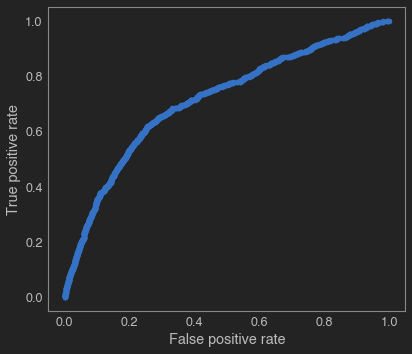

In [7]:
from jupyterthemes import jtplot

y_pred = me_valid.predict_proba(X_valid1).values

jtplot.style(theme='monokai')

fpr, tpr, thresholds = roc_curve(y_valid1, y_pred)
pit.plot(fpr, tpr, marker='o')
pit.xlabel("False positive rate")
pit.ylabel("True positive rate")
pit.grid()
pit.show()

In [8]:
me_valid.feature_importance(X_train1, 50)

,features,importance
87,調教師同コース同距離別騎乗回数偏差,354
79,調教師コース別騎乗回数偏差,353
176,騎乗騎手年間出遅れ率偏差,350
75,調教師競馬場別騎乗回数偏差,342
91,調教師年齢別年間複勝率偏差,337
113,種牡馬同コース同距離別勝率偏差,332
69,騎手同コース同距離別勝率偏差,323
22,furlong_5,322
71,騎手同コース同距離別複勝率偏差,318
83,調教師距離別騎乗回数偏差,313


In [53]:
wr = me_valid.pred_table(X_valid1, 0.7, True)
tansho_return_rate(X_valid1, wr)

点数：371 レース数:861 対象レース率:43.0% 的中率:11.9% 的中数:44 賭金:37,100円 配当合計:41,020円 最高配当:8,020円 回収率:110.6%


In [54]:
me_test= ModelEvaluator(lgb_clf, haitou, std=True)

twr = me_test.pred_table(X_test2, 0.7)
tansho_return_rate(X_test2, twr)

点数：160 レース数:369 対象レース率:43.4% 的中率:12.5% 的中数:20 賭金:16,000円 配当合計:16,710円 最高配当:3,090円 回収率:104.4%


In [48]:
## 連対
dr = build_data('./pickle_new/shinba_base.pickle', './pickle_new/peds_vec.pickle', 3, vec)
X_rentai_train1 = dr['X_train']
y_rentai_train1 = dr['y_train']
X_rentai_valid1 = dr['X_valid']
y_rentai_valid1 = dr['y_valid']
X_rentai_test2 = dr['X_test2']
y_rentai_test2 = dr['y_test2']
X_rentai_test1 = dr['X_test1']
y_rentai_test1 = dr['y_test1']

In [726]:
optuna_params(X_rentai_train1, y_rentai_train1, X_rentai_valid1, y_rentai_valid1)

[I 2022-10-27 09:26:26,614] A new study created in memory with name: no-name-55e852f2-1004-4c94-9728-23ad9da43bc9


  0%|                                                                                                              | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.392320:   0%|                                                                       | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 0.392320:  14%|#########                                                      | 1/7 [00:01<00:07,  1.23s/it][I 2022-10-27 09:26:27,854] Trial 0 finished with value: 0.3923202477617546 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.3923202477617546.


feature_fraction, val_score: 0.392320:  14%|#########                                                      | 1/7 [00:01<00:07,  1.23s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.362467	valid_1's binary_logloss: 0.39232
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.392320:  14%|#########                                                      | 1/7 [00:02<00:07,  1.23s/it]

feature_fraction, val_score: 0.392320:  29%|##################                                             | 2/7 [00:02<00:06,  1.23s/it][I 2022-10-27 09:26:29,080] Trial 1 finished with value: 0.3970027763350277 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.3923202477617546.


feature_fraction, val_score: 0.392320:  29%|##################                                             | 2/7 [00:02<00:06,  1.23s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.373494	valid_1's binary_logloss: 0.397003
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.392320:  29%|##################                                             | 2/7 [00:03<00:06,  1.23s/it]

feature_fraction, val_score: 0.392320:  43%|###########################                                    | 3/7 [00:03<00:04,  1.19s/it][I 2022-10-27 09:26:30,236] Trial 2 finished with value: 0.3982645053799014 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.3923202477617546.


feature_fraction, val_score: 0.392320:  43%|###########################                                    | 3/7 [00:03<00:04,  1.19s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.375711	valid_1's binary_logloss: 0.398265
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.392320:  43%|###########################                                    | 3/7 [00:04<00:04,  1.19s/it]

feature_fraction, val_score: 0.392320:  57%|####################################                           | 4/7 [00:04<00:03,  1.19s/it][I 2022-10-27 09:26:31,429] Trial 3 finished with value: 0.3927441168674192 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.3923202477617546.


feature_fraction, val_score: 0.392320:  57%|####################################                           | 4/7 [00:04<00:03,  1.19s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.367057	valid_1's binary_logloss: 0.392744
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.391877:  57%|####################################                           | 4/7 [00:05<00:03,  1.19s/it]

feature_fraction, val_score: 0.391877:  71%|#############################################                  | 5/7 [00:05<00:02,  1.19s/it][I 2022-10-27 09:26:32,613] Trial 4 finished with value: 0.39187720184769115 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.39187720184769115.


feature_fraction, val_score: 0.391877:  71%|#############################################                  | 5/7 [00:05<00:02,  1.19s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.367469	valid_1's binary_logloss: 0.391877
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.391877:  71%|#############################################                  | 5/7 [00:07<00:02,  1.19s/it]

feature_fraction, val_score: 0.391877:  86%|######################################################         | 6/7 [00:07<00:01,  1.19s/it][I 2022-10-27 09:26:33,794] Trial 5 finished with value: 0.39210705998108564 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.39187720184769115.


feature_fraction, val_score: 0.391877:  86%|######################################################         | 6/7 [00:07<00:01,  1.19s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.37143	valid_1's binary_logloss: 0.392107
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.391877:  86%|######################################################         | 6/7 [00:08<00:01,  1.19s/it]

feature_fraction, val_score: 0.391877: 100%|###############################################################| 7/7 [00:08<00:00,  1.18s/it]


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.357783	valid_1's binary_logloss: 0.396638




  0%|                                                                                                             | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.391877:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.390997:   0%|                                                                            | 0/20 [00:01<?, ?it/s]

num_leaves, val_score: 0.390997:   5%|###4                                                                | 1/20 [00:01<00:22,  1.21s/it][I 2022-10-27 09:26:36,099] Trial 7 finished with value: 0.39099685969338416 and parameters: {'num_leaves': 37}. Best is trial 7 with value: 0.39099685969338416.


num_leaves, val_score: 0.390997:   5%|###4                                                                | 1/20 [00:01<00:22,  1.21s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.364454	valid_1's binary_logloss: 0.390997
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:   5%|###4                                                                | 1/20 [00:02<00:22,  1.21s/it]

num_leaves, val_score: 0.387184:  10%|######8                                                             | 2/20 [00:02<00:21,  1.19s/it][I 2022-10-27 09:26:37,283] Trial 8 finished with value: 0.38718379896835514 and parameters: {'num_leaves': 43}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  10%|######8                                                             | 2/20 [00:02<00:21,  1.19s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387184
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  10%|######8                                                             | 2/20 [00:04<00:21,  1.19s/it]

num_leaves, val_score: 0.387184:  15%|##########2                                                         | 3/20 [00:04<00:25,  1.48s/it][I 2022-10-27 09:26:39,111] Trial 9 finished with value: 0.39754402076602957 and parameters: {'num_leaves': 249}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  15%|##########2                                                         | 3/20 [00:04<00:25,  1.48s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.292768	valid_1's binary_logloss: 0.397544
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  15%|##########2                                                         | 3/20 [00:06<00:25,  1.48s/it]

num_leaves, val_score: 0.387184:  20%|#############6                                                      | 4/20 [00:06<00:27,  1.69s/it][I 2022-10-27 09:26:41,127] Trial 10 finished with value: 0.3976463704733179 and parameters: {'num_leaves': 234}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  20%|#############6                                                      | 4/20 [00:06<00:27,  1.69s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.303068	valid_1's binary_logloss: 0.397646
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  20%|#############6                                                      | 4/20 [00:08<00:27,  1.69s/it]

num_leaves, val_score: 0.387184:  25%|#################                                                   | 5/20 [00:08<00:27,  1.82s/it][I 2022-10-27 09:26:43,169] Trial 11 finished with value: 0.39714798881829827 and parameters: {'num_leaves': 222}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  25%|#################                                                   | 5/20 [00:08<00:27,  1.82s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.293238	valid_1's binary_logloss: 0.397148
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  25%|#################                                                   | 5/20 [00:09<00:27,  1.82s/it]

num_leaves, val_score: 0.387184:  30%|####################4                                               | 6/20 [00:09<00:25,  1.79s/it][I 2022-10-27 09:26:44,888] Trial 12 finished with value: 0.40207955819683966 and parameters: {'num_leaves': 246}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  30%|####################4                                               | 6/20 [00:10<00:25,  1.79s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.339544	valid_1's binary_logloss: 0.40208
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  30%|####################4                                               | 6/20 [00:11<00:25,  1.79s/it]

num_leaves, val_score: 0.387184:  35%|#######################7                                            | 7/20 [00:11<00:20,  1.54s/it][I 2022-10-27 09:26:45,930] Trial 13 finished with value: 0.39327829990778046 and parameters: {'num_leaves': 26}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  35%|#######################7                                            | 7/20 [00:11<00:20,  1.54s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.370303	valid_1's binary_logloss: 0.393278
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  35%|#######################7                                            | 7/20 [00:12<00:20,  1.54s/it]

num_leaves, val_score: 0.387184:  40%|###########################2                                        | 8/20 [00:12<00:17,  1.48s/it][I 2022-10-27 09:26:47,267] Trial 14 finished with value: 0.39781915209115926 and parameters: {'num_leaves': 88}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  40%|###########################2                                        | 8/20 [00:12<00:17,  1.48s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.33309	valid_1's binary_logloss: 0.397819
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  40%|###########################2                                        | 8/20 [00:13<00:17,  1.48s/it]

num_leaves, val_score: 0.387184:  45%|##############################6                                     | 9/20 [00:14<00:16,  1.52s/it][I 2022-10-27 09:26:48,892] Trial 15 finished with value: 0.39753184888603293 and parameters: {'num_leaves': 141}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  45%|##############################6                                     | 9/20 [00:14<00:16,  1.52s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.330164	valid_1's binary_logloss: 0.397532
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  45%|##############################6                                     | 9/20 [00:16<00:16,  1.52s/it]

num_leaves, val_score: 0.387184:  50%|#################################5                                 | 10/20 [00:16<00:17,  1.78s/it][I 2022-10-27 09:26:51,259] Trial 16 finished with value: 0.3970274022579841 and parameters: {'num_leaves': 256}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  50%|#################################5                                 | 10/20 [00:16<00:17,  1.78s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.264388	valid_1's binary_logloss: 0.397027
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  50%|#################################5                                 | 10/20 [00:17<00:17,  1.78s/it]

num_leaves, val_score: 0.387184:  55%|####################################8                              | 11/20 [00:17<00:15,  1.73s/it][I 2022-10-27 09:26:52,853] Trial 17 finished with value: 0.39688894276989556 and parameters: {'num_leaves': 95}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  55%|####################################8                              | 11/20 [00:17<00:15,  1.73s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.326291	valid_1's binary_logloss: 0.396889
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  55%|####################################8                              | 11/20 [00:18<00:15,  1.73s/it]

num_leaves, val_score: 0.387184:  60%|########################################1                          | 12/20 [00:19<00:12,  1.52s/it][I 2022-10-27 09:26:53,893] Trial 18 finished with value: 0.3921284186587476 and parameters: {'num_leaves': 4}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  60%|########################################1                          | 12/20 [00:19<00:12,  1.52s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.376498	valid_1's binary_logloss: 0.392128
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  60%|########################################1                          | 12/20 [00:20<00:12,  1.52s/it]

num_leaves, val_score: 0.387184:  65%|###########################################5                       | 13/20 [00:20<00:10,  1.49s/it][I 2022-10-27 09:26:55,318] Trial 19 finished with value: 0.39267579833460486 and parameters: {'num_leaves': 52}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  65%|###########################################5                       | 13/20 [00:20<00:10,  1.49s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.342774	valid_1's binary_logloss: 0.392676
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  65%|###########################################5                       | 13/20 [00:22<00:10,  1.49s/it]

num_leaves, val_score: 0.387184:  70%|##############################################9                    | 14/20 [00:22<00:09,  1.53s/it][I 2022-10-27 09:26:56,935] Trial 20 finished with value: 0.39671096648967596 and parameters: {'num_leaves': 157}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  70%|##############################################9                    | 14/20 [00:22<00:09,  1.53s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.303653	valid_1's binary_logloss: 0.396711
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  70%|##############################################9                    | 14/20 [00:23<00:09,  1.53s/it]

num_leaves, val_score: 0.387184:  75%|##################################################2                | 15/20 [00:23<00:07,  1.43s/it][I 2022-10-27 09:26:58,145] Trial 21 finished with value: 0.39488967061943825 and parameters: {'num_leaves': 67}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  75%|##################################################2                | 15/20 [00:23<00:07,  1.43s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.346787	valid_1's binary_logloss: 0.39489
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  75%|##################################################2                | 15/20 [00:24<00:07,  1.43s/it]

num_leaves, val_score: 0.387184:  80%|#####################################################6             | 16/20 [00:24<00:05,  1.48s/it][I 2022-10-27 09:26:59,721] Trial 22 finished with value: 0.39459817622941873 and parameters: {'num_leaves': 111}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  80%|#####################################################6             | 16/20 [00:24<00:05,  1.48s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.331175	valid_1's binary_logloss: 0.394598
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  80%|#####################################################6             | 16/20 [00:25<00:05,  1.48s/it]

num_leaves, val_score: 0.387184:  85%|########################################################9          | 17/20 [00:25<00:04,  1.36s/it][I 2022-10-27 09:27:00,806] Trial 23 finished with value: 0.39343112320204915 and parameters: {'num_leaves': 40}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  85%|########################################################9          | 17/20 [00:25<00:04,  1.36s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.367821	valid_1's binary_logloss: 0.393431
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  85%|########################################################9          | 17/20 [00:27<00:04,  1.36s/it]

num_leaves, val_score: 0.387184:  90%|############################################################3      | 18/20 [00:27<00:02,  1.39s/it][I 2022-10-27 09:27:02,284] Trial 24 finished with value: 0.39790909600258506 and parameters: {'num_leaves': 179}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  90%|############################################################3      | 18/20 [00:27<00:02,  1.39s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.330351	valid_1's binary_logloss: 0.397909
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  90%|############################################################3      | 18/20 [00:28<00:02,  1.39s/it]

num_leaves, val_score: 0.387184:  95%|###############################################################6   | 19/20 [00:28<00:01,  1.29s/it][I 2022-10-27 09:27:03,336] Trial 25 finished with value: 0.3916671490344022 and parameters: {'num_leaves': 13}. Best is trial 8 with value: 0.38718379896835514.


num_leaves, val_score: 0.387184:  95%|###############################################################6   | 19/20 [00:28<00:01,  1.29s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.369486	valid_1's binary_logloss: 0.391667
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.387184:  95%|###############################################################6   | 19/20 [00:29<00:01,  1.29s/it]

num_leaves, val_score: 0.387184: 100%|###################################################################| 20/20 [00:29<00:00,  1.49s/it]


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.341968	valid_1's binary_logloss: 0.396852




  0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.387184:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:   0%|                                                                               | 0/10 [00:01<?, ?it/s]

bagging, val_score: 0.387184:  10%|#######1                                                               | 1/10 [00:01<00:09,  1.06s/it][I 2022-10-27 09:27:05,833] Trial 27 finished with value: 0.39367271353085614 and parameters: {'bagging_fraction': 0.864323790667658, 'bagging_freq': 1}. Best is trial 27 with value: 0.39367271353085614.


bagging, val_score: 0.387184:  10%|#######1                                                               | 1/10 [00:01<00:09,  1.06s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.366423	valid_1's binary_logloss: 0.393673
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  10%|#######1                                                               | 1/10 [00:02<00:09,  1.06s/it]

bagging, val_score: 0.387184:  20%|##############2                                                        | 2/10 [00:02<00:08,  1.09s/it][I 2022-10-27 09:27:06,938] Trial 28 finished with value: 0.3889937287505266 and parameters: {'bagging_fraction': 0.4212232701091194, 'bagging_freq': 7}. Best is trial 28 with value: 0.3889937287505266.


bagging, val_score: 0.387184:  20%|##############2                                                        | 2/10 [00:02<00:08,  1.09s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.348956	valid_1's binary_logloss: 0.388994
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  20%|##############2                                                        | 2/10 [00:03<00:08,  1.09s/it]

bagging, val_score: 0.387184:  30%|#####################3                                                 | 3/10 [00:03<00:07,  1.03s/it][I 2022-10-27 09:27:07,912] Trial 29 finished with value: 0.3993372371887554 and parameters: {'bagging_fraction': 0.5693592241987779, 'bagging_freq': 3}. Best is trial 28 with value: 0.3889937287505266.


bagging, val_score: 0.387184:  30%|#####################3                                                 | 3/10 [00:03<00:07,  1.03s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.3755	valid_1's binary_logloss: 0.399337
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  30%|#####################3                                                 | 3/10 [00:04<00:07,  1.03s/it]

bagging, val_score: 0.387184:  40%|############################4                                          | 4/10 [00:04<00:06,  1.09s/it][I 2022-10-27 09:27:09,088] Trial 30 finished with value: 0.4007601535273484 and parameters: {'bagging_fraction': 0.7650438748670704, 'bagging_freq': 4}. Best is trial 28 with value: 0.3889937287505266.


bagging, val_score: 0.387184:  40%|############################4                                          | 4/10 [00:04<00:06,  1.09s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.366121	valid_1's binary_logloss: 0.40076
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  40%|############################4                                          | 4/10 [00:05<00:06,  1.09s/it]

bagging, val_score: 0.387184:  50%|###################################5                                   | 5/10 [00:05<00:05,  1.11s/it][I 2022-10-27 09:27:10,230] Trial 31 finished with value: 0.39473130886547014 and parameters: {'bagging_fraction': 0.9730317015718298, 'bagging_freq': 7}. Best is trial 28 with value: 0.3889937287505266.


bagging, val_score: 0.387184:  50%|###################################5                                   | 5/10 [00:05<00:05,  1.11s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.363563	valid_1's binary_logloss: 0.394731
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  50%|###################################5                                   | 5/10 [00:06<00:05,  1.11s/it]

bagging, val_score: 0.387184:  60%|##########################################6                            | 6/10 [00:06<00:04,  1.15s/it][I 2022-10-27 09:27:11,445] Trial 32 finished with value: 0.3941777156641666 and parameters: {'bagging_fraction': 0.8479568296823062, 'bagging_freq': 5}. Best is trial 28 with value: 0.3889937287505266.


bagging, val_score: 0.387184:  60%|##########################################6                            | 6/10 [00:06<00:04,  1.15s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.347302	valid_1's binary_logloss: 0.394178
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  60%|##########################################6                            | 6/10 [00:07<00:04,  1.15s/it]

bagging, val_score: 0.387184:  70%|#################################################6                     | 7/10 [00:07<00:03,  1.17s/it][I 2022-10-27 09:27:12,671] Trial 33 finished with value: 0.3877453394118215 and parameters: {'bagging_fraction': 0.7205795955648044, 'bagging_freq': 4}. Best is trial 33 with value: 0.3877453394118215.


bagging, val_score: 0.387184:  70%|#################################################6                     | 7/10 [00:07<00:03,  1.17s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.357073	valid_1's binary_logloss: 0.387745
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  70%|#################################################6                     | 7/10 [00:09<00:03,  1.17s/it]

bagging, val_score: 0.387184:  80%|########################################################8              | 8/10 [00:09<00:02,  1.21s/it][I 2022-10-27 09:27:13,954] Trial 34 finished with value: 0.393134111842304 and parameters: {'bagging_fraction': 0.62872216332561, 'bagging_freq': 4}. Best is trial 33 with value: 0.3877453394118215.


bagging, val_score: 0.387184:  80%|########################################################8              | 8/10 [00:09<00:02,  1.21s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.34654	valid_1's binary_logloss: 0.393134
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  80%|########################################################8              | 8/10 [00:10<00:02,  1.21s/it]

bagging, val_score: 0.387184:  90%|###############################################################9       | 9/10 [00:10<00:01,  1.22s/it][I 2022-10-27 09:27:15,203] Trial 35 finished with value: 0.39082546558441433 and parameters: {'bagging_fraction': 0.8684257433048116, 'bagging_freq': 3}. Best is trial 33 with value: 0.3877453394118215.


bagging, val_score: 0.387184:  90%|###############################################################9       | 9/10 [00:10<00:01,  1.22s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.354366	valid_1's binary_logloss: 0.390825
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.387184:  90%|###############################################################9       | 9/10 [00:11<00:01,  1.22s/it]

bagging, val_score: 0.387184: 100%|######################################################################| 10/10 [00:11<00:00,  1.17s/it]


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.361491	valid_1's binary_logloss: 0.399108




  0%|                                                                                                              | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.387184:   0%|                                                                | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.387184:   0%|                                                                | 0/6 [00:01<?, ?it/s]

feature_fraction_stage2, val_score: 0.387184:  17%|#########3                                              | 1/6 [00:01<00:06,  1.23s/it][I 2022-10-27 09:27:17,675] Trial 37 finished with value: 0.39462899560618614 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.39462899560618614.


feature_fraction_stage2, val_score: 0.387184:  17%|#########3                                              | 1/6 [00:01<00:06,  1.23s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352859	valid_1's binary_logloss: 0.394629
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.387184:  17%|#########3                                              | 1/6 [00:02<00:06,  1.23s/it]

feature_fraction_stage2, val_score: 0.387184:  33%|##################6                                     | 2/6 [00:02<00:05,  1.33s/it][I 2022-10-27 09:27:19,076] Trial 38 finished with value: 0.39070811239776787 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 38 with value: 0.39070811239776787.


feature_fraction_stage2, val_score: 0.387184:  33%|##################6                                     | 2/6 [00:02<00:05,  1.33s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.348213	valid_1's binary_logloss: 0.390708
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.387184:  33%|##################6                                     | 2/6 [00:03<00:05,  1.33s/it]

feature_fraction_stage2, val_score: 0.387184:  50%|############################                            | 3/6 [00:03<00:03,  1.30s/it][I 2022-10-27 09:27:20,335] Trial 39 finished with value: 0.39556316657660107 and parameters: {'feature_fraction': 0.52}. Best is trial 38 with value: 0.39070811239776787.


feature_fraction_stage2, val_score: 0.387184:  50%|############################                            | 3/6 [00:03<00:03,  1.30s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.347341	valid_1's binary_logloss: 0.395563
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.387184:  50%|############################                            | 3/6 [00:05<00:03,  1.30s/it]

feature_fraction_stage2, val_score: 0.387184:  67%|#####################################3                  | 4/6 [00:05<00:02,  1.23s/it][I 2022-10-27 09:27:21,464] Trial 40 finished with value: 0.3939609798611426 and parameters: {'feature_fraction': 0.584}. Best is trial 38 with value: 0.39070811239776787.


feature_fraction_stage2, val_score: 0.387184:  67%|#####################################3                  | 4/6 [00:05<00:02,  1.23s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.361524	valid_1's binary_logloss: 0.393961
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.387184:  67%|#####################################3                  | 4/6 [00:06<00:02,  1.23s/it]

feature_fraction_stage2, val_score: 0.387184:  83%|##############################################6         | 5/6 [00:06<00:01,  1.23s/it][I 2022-10-27 09:27:22,698] Trial 41 finished with value: 0.39220786276390784 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 38 with value: 0.39070811239776787.


feature_fraction_stage2, val_score: 0.387184:  83%|##############################################6         | 5/6 [00:06<00:01,  1.23s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.366023	valid_1's binary_logloss: 0.392208
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.387184:  83%|##############################################6         | 5/6 [00:07<00:01,  1.23s/it]

feature_fraction_stage2, val_score: 0.387184: 100%|########################################################| 6/6 [00:07<00:00,  1.27s/it]


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.35459	valid_1's binary_logloss: 0.39351




  0%|                                                                                                             | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.387184:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387184:   0%|                                                                | 0/20 [00:01<?, ?it/s]

regularization_factors, val_score: 0.387184:   5%|##8                                                     | 1/20 [00:01<00:35,  1.86s/it][I 2022-10-27 09:27:25,913] Trial 43 finished with value: 0.3892803586305149 and parameters: {'lambda_l1': 0.0008866165022299193, 'lambda_l2': 8.314982681817135}. Best is trial 43 with value: 0.3892803586305149.


regularization_factors, val_score: 0.387184:   5%|##8                                                     | 1/20 [00:01<00:35,  1.86s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.335588	valid_1's binary_logloss: 0.38928
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387178:   5%|##8                                                     | 1/20 [00:03<00:35,  1.86s/it]

regularization_factors, val_score: 0.387178:  10%|#####6                                                  | 2/20 [00:03<00:28,  1.61s/it][I 2022-10-27 09:27:27,346] Trial 44 finished with value: 0.3871775096468315 and parameters: {'lambda_l1': 0.010054954169240392, 'lambda_l2': 7.92703932849694e-06}. Best is trial 44 with value: 0.3871775096468315.


regularization_factors, val_score: 0.387178:  10%|#####6                                                  | 2/20 [00:03<00:28,  1.61s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352071	valid_1's binary_logloss: 0.387178
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  10%|#####6                                                  | 2/20 [00:04<00:28,  1.61s/it]

regularization_factors, val_score: 0.387166:  15%|########4                                               | 3/20 [00:04<00:25,  1.50s/it][I 2022-10-27 09:27:28,720] Trial 45 finished with value: 0.3871664599584862 and parameters: {'lambda_l1': 6.59308382247429e-05, 'lambda_l2': 8.862806639932555e-06}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  15%|########4                                               | 3/20 [00:04<00:25,  1.50s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387166
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  15%|########4                                               | 3/20 [00:06<00:25,  1.50s/it]

regularization_factors, val_score: 0.387166:  20%|###########2                                            | 4/20 [00:06<00:23,  1.45s/it][I 2022-10-27 09:27:30,093] Trial 46 finished with value: 0.38716648765295714 and parameters: {'lambda_l1': 5.407114243566522e-06, 'lambda_l2': 1.4783398284531251e-05}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  20%|###########2                                            | 4/20 [00:06<00:23,  1.45s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387166
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  20%|###########2                                            | 4/20 [00:07<00:23,  1.45s/it]

regularization_factors, val_score: 0.387166:  25%|##############                                          | 5/20 [00:07<00:22,  1.51s/it][I 2022-10-27 09:27:31,713] Trial 47 finished with value: 0.3871837979714515 and parameters: {'lambda_l1': 1.4585904415539556e-08, 'lambda_l2': 5.733947498876181e-07}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  25%|##############                                          | 5/20 [00:07<00:22,  1.51s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387184
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  25%|##############                                          | 5/20 [00:09<00:22,  1.51s/it]

regularization_factors, val_score: 0.387166:  30%|################8                                       | 6/20 [00:09<00:21,  1.55s/it][I 2022-10-27 09:27:33,339] Trial 48 finished with value: 0.39070842716848836 and parameters: {'lambda_l1': 2.5123706672641012e-08, 'lambda_l2': 8.500097260126799}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  30%|################8                                       | 6/20 [00:09<00:21,  1.55s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.353077	valid_1's binary_logloss: 0.390708
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  30%|################8                                       | 6/20 [00:10<00:21,  1.55s/it]

regularization_factors, val_score: 0.387166:  35%|###################5                                    | 7/20 [00:10<00:19,  1.49s/it][I 2022-10-27 09:27:34,710] Trial 49 finished with value: 0.38718292687126143 and parameters: {'lambda_l1': 0.0003034226590108639, 'lambda_l2': 0.0004010561912889589}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  35%|###################5                                    | 7/20 [00:10<00:19,  1.49s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352061	valid_1's binary_logloss: 0.387183
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  35%|###################5                                    | 7/20 [00:12<00:19,  1.49s/it]

regularization_factors, val_score: 0.387166:  40%|######################4                                 | 8/20 [00:12<00:17,  1.46s/it][I 2022-10-27 09:27:36,091] Trial 50 finished with value: 0.38718243705093736 and parameters: {'lambda_l1': 0.0016763334972845177, 'lambda_l2': 0.00018476057200506152}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  40%|######################4                                 | 8/20 [00:12<00:17,  1.46s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352062	valid_1's binary_logloss: 0.387182
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  40%|######################4                                 | 8/20 [00:13<00:17,  1.46s/it]

regularization_factors, val_score: 0.387166:  45%|#########################2                              | 9/20 [00:13<00:16,  1.46s/it][I 2022-10-27 09:27:37,573] Trial 51 finished with value: 0.39142814210871085 and parameters: {'lambda_l1': 0.0011590122525491709, 'lambda_l2': 0.90270441784917}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  45%|#########################2                              | 9/20 [00:13<00:16,  1.46s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.350564	valid_1's binary_logloss: 0.391428
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  45%|#########################2                              | 9/20 [00:14<00:16,  1.46s/it]

regularization_factors, val_score: 0.387166:  50%|###########################5                           | 10/20 [00:14<00:14,  1.44s/it][I 2022-10-27 09:27:38,951] Trial 52 finished with value: 0.3871820694224132 and parameters: {'lambda_l1': 0.0027678014595099547, 'lambda_l2': 3.248256108212266e-08}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  50%|###########################5                           | 10/20 [00:14<00:14,  1.44s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352063	valid_1's binary_logloss: 0.387182
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  50%|###########################5                           | 10/20 [00:16<00:14,  1.44s/it]

regularization_factors, val_score: 0.387166:  55%|##############################2                        | 11/20 [00:16<00:13,  1.51s/it][I 2022-10-27 09:27:40,617] Trial 53 finished with value: 0.3950591901522945 and parameters: {'lambda_l1': 8.560212944684656, 'lambda_l2': 0.006756123423568128}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  55%|##############################2                        | 11/20 [00:16<00:13,  1.51s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.344393	valid_1's binary_logloss: 0.395059
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  55%|##############################2                        | 11/20 [00:17<00:13,  1.51s/it]

regularization_factors, val_score: 0.387166:  60%|#################################                      | 12/20 [00:17<00:11,  1.46s/it][I 2022-10-27 09:27:41,979] Trial 54 finished with value: 0.3871837867336048 and parameters: {'lambda_l1': 2.8557572378671665e-06, 'lambda_l2': 6.1583117455985835e-06}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  60%|#################################                      | 12/20 [00:17<00:11,  1.46s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387184
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  60%|#################################                      | 12/20 [00:19<00:11,  1.46s/it]

regularization_factors, val_score: 0.387166:  65%|###################################7                   | 13/20 [00:19<00:09,  1.39s/it][I 2022-10-27 09:27:43,214] Trial 55 finished with value: 0.3871806556956294 and parameters: {'lambda_l1': 1.039056855310923e-05, 'lambda_l2': 0.0018451049212492086}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  65%|###################################7                   | 13/20 [00:19<00:09,  1.39s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352065	valid_1's binary_logloss: 0.387181
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  65%|###################################7                   | 13/20 [00:20<00:09,  1.39s/it]

regularization_factors, val_score: 0.387166:  70%|######################################5                | 14/20 [00:20<00:08,  1.39s/it][I 2022-10-27 09:27:44,583] Trial 56 finished with value: 0.3871837779124705 and parameters: {'lambda_l1': 2.9727813244634297e-06, 'lambda_l2': 1.1292752456255652e-05}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  70%|######################################5                | 14/20 [00:20<00:08,  1.39s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387184
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  70%|######################################5                | 14/20 [00:21<00:08,  1.39s/it]

regularization_factors, val_score: 0.387166:  75%|#########################################2             | 15/20 [00:21<00:06,  1.36s/it][I 2022-10-27 09:27:45,865] Trial 57 finished with value: 0.3914779287474018 and parameters: {'lambda_l1': 0.07735921254356083, 'lambda_l2': 1.0714494544420077e-08}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  75%|#########################################2             | 15/20 [00:21<00:06,  1.36s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.352629	valid_1's binary_logloss: 0.391478
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  75%|#########################################2             | 15/20 [00:23<00:06,  1.36s/it]

regularization_factors, val_score: 0.387166:  80%|############################################           | 16/20 [00:23<00:05,  1.32s/it][I 2022-10-27 09:27:47,091] Trial 58 finished with value: 0.3871837850949866 and parameters: {'lambda_l1': 2.1225552033396894e-05, 'lambda_l2': 3.677520204703331e-07}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  80%|############################################           | 16/20 [00:23<00:05,  1.32s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387184
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  80%|############################################           | 16/20 [00:24<00:05,  1.32s/it]

regularization_factors, val_score: 0.387166:  85%|##############################################7        | 17/20 [00:24<00:03,  1.32s/it][I 2022-10-27 09:27:48,409] Trial 59 finished with value: 0.3924807158025944 and parameters: {'lambda_l1': 2.0801807483843914e-07, 'lambda_l2': 0.028735932054457757}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  85%|##############################################7        | 17/20 [00:24<00:03,  1.32s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.361239	valid_1's binary_logloss: 0.392481
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  85%|##############################################7        | 17/20 [00:25<00:03,  1.32s/it]

regularization_factors, val_score: 0.387166:  90%|#################################################5     | 18/20 [00:25<00:02,  1.29s/it][I 2022-10-27 09:27:49,639] Trial 60 finished with value: 0.3871822352255209 and parameters: {'lambda_l1': 6.309556105595765e-05, 'lambda_l2': 6.217795902486028e-05}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  90%|#################################################5     | 18/20 [00:25<00:02,  1.29s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387182
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  90%|#################################################5     | 18/20 [00:26<00:02,  1.29s/it]

regularization_factors, val_score: 0.387166:  95%|####################################################2  | 19/20 [00:26<00:01,  1.31s/it][I 2022-10-27 09:27:51,007] Trial 61 finished with value: 0.38718379817315224 and parameters: {'lambda_l1': 5.737245136805639e-07, 'lambda_l2': 2.45791150497666e-07}. Best is trial 45 with value: 0.3871664599584862.


regularization_factors, val_score: 0.387166:  95%|####################################################2  | 19/20 [00:26<00:01,  1.31s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.35206	valid_1's binary_logloss: 0.387184
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.387166:  95%|####################################################2  | 19/20 [00:28<00:01,  1.31s/it]

regularization_factors, val_score: 0.387166: 100%|#######################################################| 20/20 [00:28<00:00,  1.43s/it]


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.339892	valid_1's binary_logloss: 0.390322




  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.387166:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.385693:   0%|                                                                       | 0/5 [00:01<?, ?it/s]

min_data_in_leaf, val_score: 0.385693:  20%|############6                                                  | 1/5 [00:01<00:04,  1.24s/it][I 2022-10-27 09:27:53,825] Trial 63 finished with value: 0.3856929198789611 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.3856929198789611.


min_data_in_leaf, val_score: 0.385693:  20%|############6                                                  | 1/5 [00:01<00:04,  1.24s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.352476	valid_1's binary_logloss: 0.385693
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.385693:  20%|############6                                                  | 1/5 [00:02<00:04,  1.24s/it]

min_data_in_leaf, val_score: 0.385693:  40%|#########################2                                     | 2/5 [00:02<00:03,  1.27s/it][I 2022-10-27 09:27:55,123] Trial 64 finished with value: 0.3943791832485365 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.3856929198789611.


min_data_in_leaf, val_score: 0.385693:  40%|#########################2                                     | 2/5 [00:02<00:03,  1.27s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.360617	valid_1's binary_logloss: 0.394379
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.385693:  40%|#########################2                                     | 2/5 [00:03<00:03,  1.27s/it]

min_data_in_leaf, val_score: 0.385693:  60%|#####################################8                         | 3/5 [00:03<00:02,  1.35s/it][I 2022-10-27 09:27:56,555] Trial 65 finished with value: 0.3894239762843065 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.3856929198789611.


min_data_in_leaf, val_score: 0.385693:  60%|#####################################8                         | 3/5 [00:03<00:02,  1.35s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.349873	valid_1's binary_logloss: 0.389424
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.385693:  60%|#####################################8                         | 3/5 [00:05<00:02,  1.35s/it]

min_data_in_leaf, val_score: 0.385693:  80%|##################################################4            | 4/5 [00:05<00:01,  1.29s/it][I 2022-10-27 09:27:57,753] Trial 66 finished with value: 0.394184525287063 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.3856929198789611.


min_data_in_leaf, val_score: 0.385693:  80%|##################################################4            | 4/5 [00:05<00:01,  1.29s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.358667	valid_1's binary_logloss: 0.394185
[LightGBM] [Info] Number of positive: 5758, number of negative: 33145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148009 -> initscore=-1.750302
[LightGBM] [Info] Start training from score -1.750302
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.385693:  80%|##################################################4            | 4/5 [00:06<00:01,  1.29s/it]

min_data_in_leaf, val_score: 0.385693: 100%|###############################################################| 5/5 [00:06<00:00,  1.30s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.346777	valid_1's binary_logloss: 0.391633


{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 6.59308382247429e-05,
 'lambda_l2': 8.862806639932555e-06,
 'num_leaves': 43,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [6]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
'lambda_l1': 6.59308382247429e-05,
 'lambda_l2': 8.862806639932555e-06,
 'num_leaves': 43,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 1000,
}

r_lgb_clf = fit(params, X_rentai_train1, y_rentai_train1)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [728]:
r_me_valid = ModelEvaluator(r_lgb_clf, haitou, std=True)
r_me_valid.score(y_rentai_valid1, X_rentai_valid1)

0.7249498715975286

In [729]:
fm = r_me_valid.pred_table(X_rentai_valid1, 0.5)
fmr = wr[['h_num']].merge(fm[['h_num']], left_index=True, right_index=True)
fmr = fmr[fmr['h_num_x'] != fmr['h_num_y']]
umaren_return_rate(fmr, haitou)

点数：707 的中数:62 的中率:8.8%
馬連賭金:70,700円 馬連配当合計:57,370円 馬連最高配当:6,190円 馬連回収率:81.1%
馬単賭金:141,400円 馬単配当合計:111,900円 馬単最高配当:12,730円 馬単回収率:79.1%


In [730]:
r_me_test = ModelEvaluator(r_lgb_clf, haitou, std=True)
t_fm = r_me_test.pred_table(X_rentai_test2, 0.5)
fmrt = twr[['h_num']].merge(t_fm[['h_num']], left_index=True, right_index=True)
fmrt = fmrt[fmrt['h_num_x'] != fmrt['h_num_y']]

umaren_return_rate(fmrt, haitou)

点数：238 的中数:13 的中率:5.5%
馬連賭金:23,800円 馬連配当合計:9,020円 馬連最高配当:1,740円 馬連回収率:37.9%
馬単賭金:47,600円 馬単配当合計:18,240円 馬単最高配当:4,070円 馬単回収率:38.3%


In [49]:
## 複勝
df = build_data('./pickle_new/shinba_base.pickle', './pickle_new/peds_vec.pickle', 4, vec)
X_fukusho_train1 = df['X_train']
y_fukusho_train1 = df['y_train']
X_fukusho_valid1 = df['X_valid']
y_fukusho_valid1 = df['y_valid']
X_fukusho_test2 = df['X_test2']
y_fukusho_test2 = df['y_test2']
X_fukusho_test1 = df['X_test1']
y_fukusho_test1 = df['y_test1']

In [744]:
optuna_params(X_fukusho_train1, y_fukusho_train1, X_fukusho_valid1, y_fukusho_valid1)

[I 2022-10-27 09:37:38,631] A new study created in memory with name: no-name-c30ea940-27e5-4c71-8d30-96d86529b431


  0%|                                                                                                              | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.513959:   0%|                                                                       | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 0.513959:  14%|#########                                                      | 1/7 [00:01<00:07,  1.21s/it][I 2022-10-27 09:37:39,844] Trial 0 finished with value: 0.51395872477023 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.51395872477023.


feature_fraction, val_score: 0.513959:  14%|#########                                                      | 1/7 [00:01<00:07,  1.21s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.471953	valid_1's binary_logloss: 0.513959
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.513959:  14%|#########                                                      | 1/7 [00:02<00:07,  1.21s/it]

feature_fraction, val_score: 0.513959:  29%|##################                                             | 2/7 [00:02<00:06,  1.26s/it][I 2022-10-27 09:37:41,141] Trial 1 finished with value: 0.5143719733472065 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.51395872477023.


feature_fraction, val_score: 0.513959:  29%|##################                                             | 2/7 [00:02<00:06,  1.26s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.469698	valid_1's binary_logloss: 0.514372
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.506880:  29%|##################                                             | 2/7 [00:03<00:06,  1.26s/it]

feature_fraction, val_score: 0.506880:  43%|###########################                                    | 3/7 [00:03<00:04,  1.16s/it][I 2022-10-27 09:37:42,182] Trial 2 finished with value: 0.5068797467716084 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.5068797467716084.


feature_fraction, val_score: 0.506880:  43%|###########################                                    | 3/7 [00:03<00:04,  1.16s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.471314	valid_1's binary_logloss: 0.50688
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.506880:  43%|###########################                                    | 3/7 [00:04<00:04,  1.16s/it]

feature_fraction, val_score: 0.506880:  57%|####################################                           | 4/7 [00:04<00:03,  1.16s/it][I 2022-10-27 09:37:43,345] Trial 3 finished with value: 0.519340676463741 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.5068797467716084.


feature_fraction, val_score: 0.506880:  57%|####################################                           | 4/7 [00:04<00:03,  1.16s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.480824	valid_1's binary_logloss: 0.519341
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.506880:  57%|####################################                           | 4/7 [00:05<00:03,  1.16s/it]

feature_fraction, val_score: 0.506880:  71%|#############################################                  | 5/7 [00:05<00:02,  1.19s/it][I 2022-10-27 09:37:44,574] Trial 4 finished with value: 0.5094075600712527 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.5068797467716084.


feature_fraction, val_score: 0.506880:  71%|#############################################                  | 5/7 [00:05<00:02,  1.19s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.468119	valid_1's binary_logloss: 0.509408
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.506880:  71%|#############################################                  | 5/7 [00:07<00:02,  1.19s/it]

feature_fraction, val_score: 0.506880:  86%|######################################################         | 6/7 [00:07<00:01,  1.24s/it][I 2022-10-27 09:37:45,921] Trial 5 finished with value: 0.5134934286104336 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.5068797467716084.


feature_fraction, val_score: 0.506880:  86%|######################################################         | 6/7 [00:07<00:01,  1.24s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.472434	valid_1's binary_logloss: 0.513493
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.506880:  86%|######################################################         | 6/7 [00:08<00:01,  1.24s/it]

feature_fraction, val_score: 0.506880: 100%|###############################################################| 7/7 [00:08<00:00,  1.22s/it]


Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.468421	valid_1's binary_logloss: 0.510579




  0%|                                                                                                             | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.506880:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.506880:   0%|                                                                            | 0/20 [00:01<?, ?it/s]

num_leaves, val_score: 0.506880:   5%|###4                                                                | 1/20 [00:01<00:34,  1.81s/it][I 2022-10-27 09:37:49,017] Trial 7 finished with value: 0.5125892646387579 and parameters: {'num_leaves': 210}. Best is trial 7 with value: 0.5125892646387579.


num_leaves, val_score: 0.506880:   5%|###4                                                                | 1/20 [00:01<00:34,  1.81s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.410331	valid_1's binary_logloss: 0.512589
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:   5%|###4                                                                | 1/20 [00:02<00:34,  1.81s/it]

num_leaves, val_score: 0.502995:  10%|######8                                                             | 2/20 [00:02<00:24,  1.36s/it][I 2022-10-27 09:37:50,062] Trial 8 finished with value: 0.5029954690436886 and parameters: {'num_leaves': 19}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  10%|######8                                                             | 2/20 [00:02<00:24,  1.36s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.477704	valid_1's binary_logloss: 0.502995
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:  10%|######8                                                             | 2/20 [00:04<00:24,  1.36s/it]

num_leaves, val_score: 0.502995:  15%|##########2                                                         | 3/20 [00:04<00:24,  1.42s/it][I 2022-10-27 09:37:51,540] Trial 9 finished with value: 0.5171624043558594 and parameters: {'num_leaves': 239}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  15%|##########2                                                         | 3/20 [00:04<00:24,  1.42s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.459851	valid_1's binary_logloss: 0.517162
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:  15%|##########2                                                         | 3/20 [00:06<00:24,  1.42s/it]

num_leaves, val_score: 0.502995:  20%|#############6                                                      | 4/20 [00:06<00:25,  1.58s/it][I 2022-10-27 09:37:53,376] Trial 10 finished with value: 0.5167629593939853 and parameters: {'num_leaves': 243}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  20%|#############6                                                      | 4/20 [00:06<00:25,  1.58s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.423731	valid_1's binary_logloss: 0.516763
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:  20%|#############6                                                      | 4/20 [00:07<00:25,  1.58s/it]

num_leaves, val_score: 0.502995:  25%|#################                                                   | 5/20 [00:07<00:24,  1.65s/it][I 2022-10-27 09:37:55,152] Trial 11 finished with value: 0.509765718448088 and parameters: {'num_leaves': 219}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  25%|#################                                                   | 5/20 [00:07<00:24,  1.65s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.408251	valid_1's binary_logloss: 0.509766
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:  25%|#################                                                   | 5/20 [00:09<00:24,  1.65s/it]

num_leaves, val_score: 0.502995:  30%|####################4                                               | 6/20 [00:09<00:23,  1.65s/it][I 2022-10-27 09:37:56,804] Trial 12 finished with value: 0.5171624043558594 and parameters: {'num_leaves': 239}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  30%|####################4                                               | 6/20 [00:09<00:23,  1.65s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.459851	valid_1's binary_logloss: 0.517162
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:  30%|####################4                                               | 6/20 [00:11<00:23,  1.65s/it]

num_leaves, val_score: 0.502995:  35%|#######################7                                            | 7/20 [00:11<00:20,  1.57s/it][I 2022-10-27 09:37:58,219] Trial 13 finished with value: 0.5093348454362675 and parameters: {'num_leaves': 172}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  35%|#######################7                                            | 7/20 [00:11<00:20,  1.57s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.439679	valid_1's binary_logloss: 0.509335
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.502995:  35%|#######################7                                            | 7/20 [00:12<00:20,  1.57s/it]

num_leaves, val_score: 0.502995:  40%|###########################2                                        | 8/20 [00:12<00:17,  1.46s/it][I 2022-10-27 09:37:59,447] Trial 14 finished with value: 0.5176883644417931 and parameters: {'num_leaves': 249}. Best is trial 8 with value: 0.5029954690436886.


num_leaves, val_score: 0.502995:  40%|###########################2                                        | 8/20 [00:12<00:17,  1.46s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.510645	valid_1's binary_logloss: 0.517688
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.500808:  40%|###########################2                                        | 8/20 [00:13<00:17,  1.46s/it]

num_leaves, val_score: 0.500808:  45%|##############################6                                     | 9/20 [00:13<00:14,  1.32s/it][I 2022-10-27 09:38:00,438] Trial 15 finished with value: 0.5008078034721838 and parameters: {'num_leaves': 7}. Best is trial 15 with value: 0.5008078034721838.


num_leaves, val_score: 0.500808:  45%|##############################6                                     | 9/20 [00:13<00:14,  1.32s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.472374	valid_1's binary_logloss: 0.500808
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.500808:  45%|##############################6                                     | 9/20 [00:14<00:14,  1.32s/it]

num_leaves, val_score: 0.500808:  50%|#################################5                                 | 10/20 [00:14<00:13,  1.38s/it][I 2022-10-27 09:38:01,957] Trial 16 finished with value: 0.5093348454362675 and parameters: {'num_leaves': 172}. Best is trial 15 with value: 0.5008078034721838.


num_leaves, val_score: 0.500808:  50%|#################################5                                 | 10/20 [00:14<00:13,  1.38s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.439679	valid_1's binary_logloss: 0.509335
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  50%|#################################5                                 | 10/20 [00:15<00:13,  1.38s/it]

num_leaves, val_score: 0.498622:  55%|####################################8                              | 11/20 [00:15<00:11,  1.27s/it][I 2022-10-27 09:38:02,988] Trial 17 finished with value: 0.4986223655759058 and parameters: {'num_leaves': 11}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  55%|####################################8                              | 11/20 [00:15<00:11,  1.27s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.466701	valid_1's binary_logloss: 0.498622
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  55%|####################################8                              | 11/20 [00:16<00:11,  1.27s/it]

num_leaves, val_score: 0.498622:  60%|########################################1                          | 12/20 [00:16<00:09,  1.20s/it][I 2022-10-27 09:38:04,035] Trial 18 finished with value: 0.5058584453735522 and parameters: {'num_leaves': 26}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  60%|########################################1                          | 12/20 [00:16<00:09,  1.20s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.460458	valid_1's binary_logloss: 0.505858
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  60%|########################################1                          | 12/20 [00:17<00:09,  1.20s/it]

num_leaves, val_score: 0.498622:  65%|###########################################5                       | 13/20 [00:17<00:08,  1.18s/it][I 2022-10-27 09:38:05,168] Trial 19 finished with value: 0.5038591235161635 and parameters: {'num_leaves': 68}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  65%|###########################################5                       | 13/20 [00:17<00:08,  1.18s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.456011	valid_1's binary_logloss: 0.503859
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  65%|###########################################5                       | 13/20 [00:19<00:08,  1.18s/it]

num_leaves, val_score: 0.498622:  70%|##############################################9                    | 14/20 [00:19<00:07,  1.18s/it][I 2022-10-27 09:38:06,358] Trial 20 finished with value: 0.5025353927953486 and parameters: {'num_leaves': 77}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  70%|##############################################9                    | 14/20 [00:19<00:07,  1.18s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.449155	valid_1's binary_logloss: 0.502535
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  70%|##############################################9                    | 14/20 [00:20<00:07,  1.18s/it]

num_leaves, val_score: 0.498622:  75%|##################################################2                | 15/20 [00:20<00:05,  1.17s/it][I 2022-10-27 09:38:07,502] Trial 21 finished with value: 0.5012390681642991 and parameters: {'num_leaves': 64}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  75%|##################################################2                | 15/20 [00:20<00:05,  1.17s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.454577	valid_1's binary_logloss: 0.501239
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  75%|##################################################2                | 15/20 [00:21<00:05,  1.17s/it]

num_leaves, val_score: 0.498622:  80%|#####################################################6             | 16/20 [00:21<00:04,  1.10s/it][I 2022-10-27 09:38:08,438] Trial 22 finished with value: 0.5008078034721838 and parameters: {'num_leaves': 7}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  80%|#####################################################6             | 16/20 [00:21<00:04,  1.10s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.472374	valid_1's binary_logloss: 0.500808
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  80%|#####################################################6             | 16/20 [00:22<00:04,  1.10s/it]

num_leaves, val_score: 0.498622:  85%|########################################################9          | 17/20 [00:22<00:03,  1.14s/it][I 2022-10-27 09:38:09,668] Trial 23 finished with value: 0.505840338075511 and parameters: {'num_leaves': 102}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  85%|########################################################9          | 17/20 [00:22<00:03,  1.14s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448479	valid_1's binary_logloss: 0.50584
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  85%|########################################################9          | 17/20 [00:23<00:03,  1.14s/it]

num_leaves, val_score: 0.498622:  90%|############################################################3      | 18/20 [00:23<00:02,  1.10s/it][I 2022-10-27 09:38:10,679] Trial 24 finished with value: 0.506086235270843 and parameters: {'num_leaves': 42}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  90%|############################################################3      | 18/20 [00:23<00:02,  1.10s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.466415	valid_1's binary_logloss: 0.506086
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  90%|############################################################3      | 18/20 [00:24<00:02,  1.10s/it]

num_leaves, val_score: 0.498622:  95%|###############################################################6   | 19/20 [00:24<00:01,  1.12s/it][I 2022-10-27 09:38:11,839] Trial 25 finished with value: 0.5105722238518535 and parameters: {'num_leaves': 112}. Best is trial 17 with value: 0.4986223655759058.


num_leaves, val_score: 0.498622:  95%|###############################################################6   | 19/20 [00:24<00:01,  1.12s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.465261	valid_1's binary_logloss: 0.510572
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.498622:  95%|###############################################################6   | 19/20 [00:25<00:01,  1.12s/it]

num_leaves, val_score: 0.498622: 100%|###################################################################| 20/20 [00:25<00:00,  1.28s/it]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.466415	valid_1's binary_logloss: 0.506086




  0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.498622:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.498622:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.498622:  10%|#######1                                                               | 1/10 [00:00<00:08,  1.04it/s][I 2022-10-27 09:38:13,853] Trial 27 finished with value: 0.5029893715690007 and parameters: {'bagging_fraction': 0.7705467630972831, 'bagging_freq': 7}. Best is trial 27 with value: 0.5029893715690007.


bagging, val_score: 0.498622:  10%|#######1                                                               | 1/10 [00:00<00:08,  1.04it/s]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.464453	valid_1's binary_logloss: 0.502989
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.498622:  10%|#######1                                                               | 1/10 [00:02<00:08,  1.04it/s]

bagging, val_score: 0.498622:  20%|##############2                                                        | 2/10 [00:02<00:08,  1.01s/it][I 2022-10-27 09:38:14,895] Trial 28 finished with value: 0.5032379155897103 and parameters: {'bagging_fraction': 0.7464673390160204, 'bagging_freq': 5}. Best is trial 27 with value: 0.5029893715690007.


bagging, val_score: 0.498622:  20%|##############2                                                        | 2/10 [00:02<00:08,  1.01s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.45845	valid_1's binary_logloss: 0.503238
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238




bagging, val_score: 0.498622:  20%|##############2                                                        | 2/10 [00:02<00:08,  1.01s/it]

bagging, val_score: 0.498622:  30%|#####################3                                                 | 3/10 [00:02<00:06,  1.05it/s][I 2022-10-27 09:38:15,777] Trial 29 finished with value: 0.5007917333080415 and parameters: {'bagging_fraction': 0.9422382364130405, 'bagging_freq': 6}. Best is trial 29 with value: 0.5007917333080415.


bagging, val_score: 0.498622:  30%|#####################3                                                 | 3/10 [00:02<00:06,  1.05it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.481201	valid_1's binary_logloss: 0.500792
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.498622:  30%|#####################3                                                 | 3/10 [00:03<00:06,  1.05it/s]

bagging, val_score: 0.498622:  40%|############################4                                          | 4/10 [00:03<00:05,  1.04it/s][I 2022-10-27 09:38:16,761] Trial 30 finished with value: 0.5024480855163592 and parameters: {'bagging_fraction': 0.7925094761445364, 'bagging_freq': 2}. Best is trial 29 with value: 0.5007917333080415.


bagging, val_score: 0.498622:  40%|############################4                                          | 4/10 [00:03<00:05,  1.04it/s]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.464454	valid_1's binary_logloss: 0.502448
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.498622:  40%|############################4                                          | 4/10 [00:04<00:05,  1.04it/s]

bagging, val_score: 0.498622:  50%|###################################5                                   | 5/10 [00:04<00:04,  1.04it/s][I 2022-10-27 09:38:17,717] Trial 31 finished with value: 0.4992383393501547 and parameters: {'bagging_fraction': 0.9928283957325778, 'bagging_freq': 4}. Best is trial 31 with value: 0.4992383393501547.


bagging, val_score: 0.498622:  50%|###################################5                                   | 5/10 [00:04<00:04,  1.04it/s]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.47137	valid_1's binary_logloss: 0.499238
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238




bagging, val_score: 0.498622:  50%|###################################5                                   | 5/10 [00:05<00:04,  1.04it/s]

bagging, val_score: 0.498622:  60%|##########################################6                            | 6/10 [00:05<00:03,  1.08it/s][I 2022-10-27 09:38:18,569] Trial 32 finished with value: 0.5053996145117096 and parameters: {'bagging_fraction': 0.6460372192821763, 'bagging_freq': 7}. Best is trial 31 with value: 0.4992383393501547.


bagging, val_score: 0.498622:  60%|##########################################6                            | 6/10 [00:05<00:03,  1.08it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.483126	valid_1's binary_logloss: 0.5054
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238




bagging, val_score: 0.498575:  60%|##########################################6                            | 6/10 [00:06<00:03,  1.08it/s]

bagging, val_score: 0.498575:  70%|#################################################6                     | 7/10 [00:06<00:02,  1.09it/s][I 2022-10-27 09:38:19,466] Trial 33 finished with value: 0.4985753720883653 and parameters: {'bagging_fraction': 0.7423951320188933, 'bagging_freq': 4}. Best is trial 33 with value: 0.4985753720883653.


bagging, val_score: 0.498575:  70%|#################################################6                     | 7/10 [00:06<00:02,  1.09it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.476499	valid_1's binary_logloss: 0.498575
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.498331:  70%|#################################################6                     | 7/10 [00:07<00:02,  1.09it/s]

bagging, val_score: 0.498331:  80%|########################################################8              | 8/10 [00:07<00:01,  1.08it/s][I 2022-10-27 09:38:20,424] Trial 34 finished with value: 0.4983309999374369 and parameters: {'bagging_fraction': 0.9493683214443642, 'bagging_freq': 3}. Best is trial 34 with value: 0.4983309999374369.


bagging, val_score: 0.498331:  80%|########################################################8              | 8/10 [00:07<00:01,  1.08it/s]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.471545	valid_1's binary_logloss: 0.498331
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.498331:  80%|########################################################8              | 8/10 [00:08<00:01,  1.08it/s]

bagging, val_score: 0.498331:  90%|###############################################################9       | 9/10 [00:08<00:00,  1.06it/s][I 2022-10-27 09:38:21,408] Trial 35 finished with value: 0.5030204210227899 and parameters: {'bagging_fraction': 0.8370553157406617, 'bagging_freq': 6}. Best is trial 34 with value: 0.4983309999374369.


bagging, val_score: 0.498331:  90%|###############################################################9       | 9/10 [00:08<00:00,  1.06it/s]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.46443	valid_1's binary_logloss: 0.50302
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.496966:  90%|###############################################################9       | 9/10 [00:09<00:00,  1.06it/s]

bagging, val_score: 0.496966: 100%|######################################################################| 10/10 [00:09<00:00,  1.04it/s]


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.454573	valid_1's binary_logloss: 0.496966




  0%|                                                                                                              | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.496966:   0%|                                                                | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.496966:   0%|                                                                | 0/3 [00:01<?, ?it/s]

feature_fraction_stage2, val_score: 0.496966:  33%|##################6                                     | 1/3 [00:01<00:02,  1.07s/it][I 2022-10-27 09:38:23,549] Trial 37 finished with value: 0.5000982404616019 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.5000982404616019.


feature_fraction_stage2, val_score: 0.496966:  33%|##################6                                     | 1/3 [00:01<00:02,  1.07s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457037	valid_1's binary_logloss: 0.500098
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.492694:  33%|##################6                                     | 1/3 [00:02<00:02,  1.07s/it]

feature_fraction_stage2, val_score: 0.492694:  67%|#####################################3                  | 2/3 [00:02<00:01,  1.11s/it][I 2022-10-27 09:38:24,685] Trial 38 finished with value: 0.492693951127877 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 0.492693951127877.


feature_fraction_stage2, val_score: 0.492694:  67%|#####################################3                  | 2/3 [00:02<00:01,  1.11s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.451777	valid_1's binary_logloss: 0.492694
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.492694:  67%|#####################################3                  | 2/3 [00:03<00:01,  1.11s/it]

feature_fraction_stage2, val_score: 0.492694: 100%|########################################################| 3/3 [00:03<00:00,  1.07s/it]


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.462482	valid_1's binary_logloss: 0.496742




  0%|                                                                                                             | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.492694:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:   0%|                                                                | 0/20 [00:01<?, ?it/s]

regularization_factors, val_score: 0.492598:   5%|##8                                                     | 1/20 [00:01<00:21,  1.14s/it][I 2022-10-27 09:38:26,822] Trial 40 finished with value: 0.49259842549610594 and parameters: {'lambda_l1': 0.0037341833907004714, 'lambda_l2': 8.766254944268345e-06}. Best is trial 40 with value: 0.49259842549610594.


regularization_factors, val_score: 0.492598:   5%|##8                                                     | 1/20 [00:01<00:21,  1.14s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.451385	valid_1's binary_logloss: 0.492598
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:   5%|##8                                                     | 1/20 [00:02<00:21,  1.14s/it]

regularization_factors, val_score: 0.492598:  10%|#####6                                                  | 2/20 [00:02<00:19,  1.10s/it][I 2022-10-27 09:38:27,886] Trial 41 finished with value: 0.494824144240539 and parameters: {'lambda_l1': 1.5067092928000082e-06, 'lambda_l2': 5.224500887709913e-06}. Best is trial 40 with value: 0.49259842549610594.


regularization_factors, val_score: 0.492598:  10%|#####6                                                  | 2/20 [00:02<00:19,  1.10s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457645	valid_1's binary_logloss: 0.494824
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  10%|#####6                                                  | 2/20 [00:03<00:19,  1.10s/it]

regularization_factors, val_score: 0.492598:  15%|########4                                               | 3/20 [00:03<00:19,  1.12s/it][I 2022-10-27 09:38:29,035] Trial 42 finished with value: 0.4925983755612147 and parameters: {'lambda_l1': 0.0008968994589519624, 'lambda_l2': 0.00028174933897974074}. Best is trial 42 with value: 0.4925983755612147.


regularization_factors, val_score: 0.492598:  15%|########4                                               | 3/20 [00:03<00:19,  1.12s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.451384	valid_1's binary_logloss: 0.492598
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  15%|########4                                               | 3/20 [00:04<00:19,  1.12s/it]

regularization_factors, val_score: 0.492598:  20%|###########2                                            | 4/20 [00:04<00:18,  1.13s/it][I 2022-10-27 09:38:30,190] Trial 43 finished with value: 0.49259830117356734 and parameters: {'lambda_l1': 1.0540212292036327e-06, 'lambda_l2': 0.0038889009848536125}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  20%|###########2                                            | 4/20 [00:04<00:18,  1.13s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.451385	valid_1's binary_logloss: 0.492598
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  20%|###########2                                            | 4/20 [00:05<00:18,  1.13s/it]

regularization_factors, val_score: 0.492598:  25%|##############                                          | 5/20 [00:05<00:17,  1.15s/it][I 2022-10-27 09:38:31,357] Trial 44 finished with value: 0.4934564645926595 and parameters: {'lambda_l1': 6.334256801065898, 'lambda_l2': 1.2730028184969986e-05}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  25%|##############                                          | 5/20 [00:05<00:17,  1.15s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.453111	valid_1's binary_logloss: 0.493456
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  25%|##############                                          | 5/20 [00:06<00:17,  1.15s/it]

regularization_factors, val_score: 0.492598:  30%|################8                                       | 6/20 [00:06<00:15,  1.12s/it][I 2022-10-27 09:38:32,425] Trial 45 finished with value: 0.49706608707626243 and parameters: {'lambda_l1': 3.2804716293209104, 'lambda_l2': 5.175893467236281}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  30%|################8                                       | 6/20 [00:06<00:15,  1.12s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.458069	valid_1's binary_logloss: 0.497066
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  30%|################8                                       | 6/20 [00:07<00:15,  1.12s/it]

regularization_factors, val_score: 0.492598:  35%|###################5                                    | 7/20 [00:07<00:14,  1.10s/it][I 2022-10-27 09:38:33,497] Trial 46 finished with value: 0.49657839071944493 and parameters: {'lambda_l1': 1.7160898613867799, 'lambda_l2': 7.706162574192265e-06}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  35%|###################5                                    | 7/20 [00:07<00:14,  1.10s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.458085	valid_1's binary_logloss: 0.496578
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  35%|###################5                                    | 7/20 [00:08<00:14,  1.10s/it]

regularization_factors, val_score: 0.492598:  40%|######################4                                 | 8/20 [00:08<00:13,  1.12s/it][I 2022-10-27 09:38:34,661] Trial 47 finished with value: 0.4925985126635042 and parameters: {'lambda_l1': 0.00925378337891499, 'lambda_l2': 0.00010124127135000476}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  40%|######################4                                 | 8/20 [00:08<00:13,  1.12s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.451387	valid_1's binary_logloss: 0.492599
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  40%|######################4                                 | 8/20 [00:10<00:13,  1.12s/it]

regularization_factors, val_score: 0.492598:  45%|#########################2                              | 9/20 [00:10<00:12,  1.10s/it][I 2022-10-27 09:38:35,718] Trial 48 finished with value: 0.4948241441249636 and parameters: {'lambda_l1': 1.1037697929202378e-06, 'lambda_l2': 3.1241171122812036e-07}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  45%|#########################2                              | 9/20 [00:10<00:12,  1.10s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457645	valid_1's binary_logloss: 0.494824
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  45%|#########################2                              | 9/20 [00:11<00:12,  1.10s/it]

regularization_factors, val_score: 0.492598:  50%|###########################5                           | 10/20 [00:11<00:10,  1.09s/it][I 2022-10-27 09:38:36,790] Trial 49 finished with value: 0.4960355195834047 and parameters: {'lambda_l1': 1.2211597072870697, 'lambda_l2': 1.7399716804410915e-07}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  50%|###########################5                           | 10/20 [00:11<00:10,  1.09s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.458328	valid_1's binary_logloss: 0.496036
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  50%|###########################5                           | 10/20 [00:12<00:10,  1.09s/it]

regularization_factors, val_score: 0.492598:  55%|##############################2                        | 11/20 [00:12<00:09,  1.09s/it][I 2022-10-27 09:38:37,878] Trial 50 finished with value: 0.4950428197773051 and parameters: {'lambda_l1': 1.1754679277646765e-08, 'lambda_l2': 0.07150302813517316}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  55%|##############################2                        | 11/20 [00:12<00:09,  1.09s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.456622	valid_1's binary_logloss: 0.495043
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  55%|##############################2                        | 11/20 [00:13<00:09,  1.09s/it]

regularization_factors, val_score: 0.492598:  60%|#################################                      | 12/20 [00:13<00:08,  1.12s/it][I 2022-10-27 09:38:39,049] Trial 51 finished with value: 0.4925983077804765 and parameters: {'lambda_l1': 2.3797813288619324e-05, 'lambda_l2': 0.003510124147492787}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  60%|#################################                      | 12/20 [00:13<00:08,  1.12s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.451385	valid_1's binary_logloss: 0.492598
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  60%|#################################                      | 12/20 [00:14<00:08,  1.12s/it]

regularization_factors, val_score: 0.492598:  65%|###################################7                   | 13/20 [00:14<00:07,  1.11s/it][I 2022-10-27 09:38:40,156] Trial 52 finished with value: 0.49491664117687756 and parameters: {'lambda_l1': 1.1316575742385512e-05, 'lambda_l2': 0.014540489409459229}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  65%|###################################7                   | 13/20 [00:14<00:07,  1.11s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.456124	valid_1's binary_logloss: 0.494917
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  65%|###################################7                   | 13/20 [00:15<00:07,  1.11s/it]

regularization_factors, val_score: 0.492598:  70%|######################################5                | 14/20 [00:15<00:06,  1.10s/it][I 2022-10-27 09:38:41,237] Trial 53 finished with value: 0.4949167260650425 and parameters: {'lambda_l1': 3.7343753258010245e-05, 'lambda_l2': 0.013246923813862787}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  70%|######################################5                | 14/20 [00:15<00:06,  1.10s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.456124	valid_1's binary_logloss: 0.494917
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  70%|######################################5                | 14/20 [00:16<00:06,  1.10s/it]

regularization_factors, val_score: 0.492598:  75%|#########################################2             | 15/20 [00:16<00:05,  1.09s/it][I 2022-10-27 09:38:42,297] Trial 54 finished with value: 0.4950167828011999 and parameters: {'lambda_l1': 2.2013268212567695e-08, 'lambda_l2': 0.3057683039445158}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  75%|#########################################2             | 15/20 [00:16<00:05,  1.09s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.458082	valid_1's binary_logloss: 0.495017
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  75%|#########################################2             | 15/20 [00:17<00:05,  1.09s/it]

regularization_factors, val_score: 0.492598:  80%|############################################           | 16/20 [00:17<00:04,  1.09s/it][I 2022-10-27 09:38:43,382] Trial 55 finished with value: 0.49482393393035096 and parameters: {'lambda_l1': 2.8048593622345324e-07, 'lambda_l2': 0.0015013823426511688}. Best is trial 43 with value: 0.49259830117356734.


regularization_factors, val_score: 0.492598:  80%|############################################           | 16/20 [00:17<00:04,  1.09s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457645	valid_1's binary_logloss: 0.494824
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  80%|############################################           | 16/20 [00:18<00:04,  1.09s/it]

regularization_factors, val_score: 0.492598:  85%|##############################################7        | 17/20 [00:18<00:03,  1.11s/it][I 2022-10-27 09:38:44,533] Trial 56 finished with value: 0.4925983004940676 and parameters: {'lambda_l1': 3.640904686873066e-05, 'lambda_l2': 0.003963059756688013}. Best is trial 56 with value: 0.4925983004940676.


regularization_factors, val_score: 0.492598:  85%|##############################################7        | 17/20 [00:18<00:03,  1.11s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.451386	valid_1's binary_logloss: 0.492598
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  85%|##############################################7        | 17/20 [00:19<00:03,  1.11s/it]

regularization_factors, val_score: 0.492598:  90%|#################################################5     | 18/20 [00:19<00:02,  1.09s/it][I 2022-10-27 09:38:45,575] Trial 57 finished with value: 0.49686763706923437 and parameters: {'lambda_l1': 0.03280262160679251, 'lambda_l2': 0.5445956749707008}. Best is trial 56 with value: 0.4925983004940676.


regularization_factors, val_score: 0.492598:  90%|#################################################5     | 18/20 [00:19<00:02,  1.09s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.459945	valid_1's binary_logloss: 0.496868
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  90%|#################################################5     | 18/20 [00:20<00:02,  1.09s/it]

regularization_factors, val_score: 0.492598:  95%|####################################################2  | 19/20 [00:20<00:01,  1.08s/it][I 2022-10-27 09:38:46,652] Trial 58 finished with value: 0.49482414273924097 and parameters: {'lambda_l1': 0.00018713490960522444, 'lambda_l2': 1.3327447822996377e-08}. Best is trial 56 with value: 0.4925983004940676.


regularization_factors, val_score: 0.492598:  95%|####################################################2  | 19/20 [00:20<00:01,  1.08s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457645	valid_1's binary_logloss: 0.494824
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.492598:  95%|####################################################2  | 19/20 [00:22<00:01,  1.08s/it]

regularization_factors, val_score: 0.492598: 100%|#######################################################| 20/20 [00:22<00:00,  1.10s/it]


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457645	valid_1's binary_logloss: 0.494824




  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.492598:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.492598:   0%|                                                                       | 0/5 [00:01<?, ?it/s]

min_data_in_leaf, val_score: 0.492598:  20%|############6                                                  | 1/5 [00:01<00:04,  1.04s/it][I 2022-10-27 09:38:48,755] Trial 60 finished with value: 0.4952446680149182 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.4952446680149182.


min_data_in_leaf, val_score: 0.492598:  20%|############6                                                  | 1/5 [00:01<00:04,  1.04s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.458474	valid_1's binary_logloss: 0.495245
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.492598:  20%|############6                                                  | 1/5 [00:02<00:04,  1.04s/it]

min_data_in_leaf, val_score: 0.492598:  40%|#########################2                                     | 2/5 [00:02<00:03,  1.10s/it][I 2022-10-27 09:38:49,900] Trial 61 finished with value: 0.49507773416997036 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.49507773416997036.


min_data_in_leaf, val_score: 0.492598:  40%|#########################2                                     | 2/5 [00:02<00:03,  1.10s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.458023	valid_1's binary_logloss: 0.495078
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.492598:  40%|#########################2                                     | 2/5 [00:03<00:03,  1.10s/it]

min_data_in_leaf, val_score: 0.492598:  60%|#####################################8                         | 3/5 [00:03<00:02,  1.08s/it][I 2022-10-27 09:38:50,962] Trial 62 finished with value: 0.49828121726108876 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.49507773416997036.


min_data_in_leaf, val_score: 0.492598:  60%|#####################################8                         | 3/5 [00:03<00:02,  1.08s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.459634	valid_1's binary_logloss: 0.498281
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.492598:  60%|#####################################8                         | 3/5 [00:04<00:02,  1.08s/it]

min_data_in_leaf, val_score: 0.492598:  80%|##################################################4            | 4/5 [00:04<00:01,  1.06s/it][I 2022-10-27 09:38:51,999] Trial 63 finished with value: 0.49800722881893783 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.49507773416997036.


min_data_in_leaf, val_score: 0.492598:  80%|##################################################4            | 4/5 [00:04<00:01,  1.06s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.459739	valid_1's binary_logloss: 0.498007
[LightGBM] [Info] Number of positive: 8626, number of negative: 30277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36823
[LightGBM] [Info] Number of data points in the train set: 38903, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221731 -> initscore=-1.255607
[LightGBM] [Info] Start training from score -1.255607
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.492598:  80%|##################################################4            | 4/5 [00:05<00:01,  1.06s/it]

min_data_in_leaf, val_score: 0.492598: 100%|###############################################################| 5/5 [00:05<00:00,  1.07s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.458517	valid_1's binary_logloss: 0.495455


{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 3.640904686873066e-05,
 'lambda_l2': 0.003963059756688013,
 'num_leaves': 11,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 0.5297970154731599,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [8]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 3.640904686873066e-05,
 'lambda_l2': 0.003963059756688013,
 'num_leaves': 11,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 0.5297970154731599,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
}

f_lgb_clf = fit(params, X_fukusho_train1, y_fukusho_train1)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [747]:
f_me_valid = ModelEvaluator(f_lgb_clf, haitou, std=True)
f_me_valid.score(y_fukusho_valid1, X_fukusho_valid1)

0.7289507372280624

In [758]:
rfm = f_me_valid.pred_table(X_fukusho_valid1, 0.5)

fmr = wr[['h_num']].merge(rfm[['h_num']], left_index=True, right_index=True)
fmr = fmr[fmr['h_num_x'] != fmr['h_num_y']]
umaren_return_rate(fmr, haitou)

sanren = fmr[['h_num_x', 'h_num_y']].merge(rfm, left_index=True, right_index=True)
uma3 = sanren[((sanren['h_num'] != sanren['h_num_y']) & (sanren['h_num'] != sanren['h_num_x']))]
uma3 = uma3.merge(haitou[[
    '1着馬番', '2着馬番', '3着馬番', '3連複', '3連単',
    "wide1_uma1", "wide1_uma2", "wide2_uma1", "wide2_uma2", "wide3_uma1", "wide3_uma2", "wide4_uma1", "wide4_uma2", "wide5_uma1", "wide5_uma2", "wide6_uma1", "wide6_uma2", "wide7_uma1", "wide7_uma2",
    "wide_1", "wide_2", "wide_3", "wide_4", "wide_5", "wide_6", "wide_7"
]], on='race_id')

sanrenkei(uma3)
wide_rate(uma3)

点数：1488 的中数:123 的中率:8.3%
馬連賭金:148,800円 馬連配当合計:181,760円 馬連最高配当:41,660円 馬連回収率:122.2%
馬単賭金:297,600円 馬単配当合計:374,990円 馬単最高配当:86,120円 馬単回収率:126.0%
点数：2472 的中数:76 的中率:3.1%
3連複賭金:247,200円 3連複配当合計:149,380円 3連複最高配当:8,750円 3連複回収率:60.4%
3連単賭金:1,483,200円 3連単配当合計:776,520円 3連単最高配当:45,760円 3連単回収率:52.4%
ワイド点数：3756 ワイド賭金:375,600円 ワイド配当合計:317,410円 ワイド的中数:482 ワイド的中率:12.8% ワイド回収率:84.5%


In [759]:
f_me_test = ModelEvaluator(f_lgb_clf, haitou, std=True)
t_rfm = f_me_test.pred_table(X_fukusho_test2, 0.5)

t_fmr = twr[['h_num']].merge(t_rfm[['h_num']], left_index=True, right_index=True)
t_fmr = t_fmr[t_fmr['h_num_x'] != t_fmr['h_num_y']]
umaren_return_rate(t_fmr, haitou)

t_sanren = fmrt[['h_num_x', 'h_num_y']].merge(t_rfm, left_index=True, right_index=True)
uma3 = t_sanren[((t_sanren['h_num'] != t_sanren['h_num_y']) & (t_sanren['h_num'] != t_sanren['h_num_x']))]
uma3 = uma3.merge(haitou[[
    '1着馬番', '2着馬番', '3着馬番', '3連複', '3連単',
    "wide1_uma1", "wide1_uma2", "wide2_uma1", "wide2_uma2", "wide3_uma1", "wide3_uma2", "wide4_uma1", "wide4_uma2", "wide5_uma1", "wide5_uma2", "wide6_uma1", "wide6_uma2", "wide7_uma1", "wide7_uma2",
    "wide_1", "wide_2", "wide_3", "wide_4", "wide_5", "wide_6", "wide_7"
]], on='race_id')

sanrenkei(uma3)
wide_rate(uma3)

点数：631 的中数:34 的中率:5.4%
馬連賭金:63,100円 馬連配当合計:49,450円 馬連最高配当:9,110円 馬連回収率:78.4%
馬単賭金:126,200円 馬単配当合計:106,920円 馬単最高配当:27,470円 馬単回収率:84.7%
点数：443 的中数:6 的中率:1.4%
3連複賭金:44,300円 3連複配当合計:12,720円 3連複最高配当:3,750円 3連複回収率:28.7%
3連単賭金:265,800円 3連単配当合計:49,220円 3連単最高配当:11,220円 3連単回収率:18.5%
ワイド点数：926 ワイド賭金:92,600円 ワイド配当合計:48,340円 ワイド的中数:86 ワイド的中率:9.3% ワイド回収率:52.2%


In [50]:
import math

race_grade = pd.read_csv('./csv_new2/20221127/races.csv')
race_grade = race_grade.set_index('race_id')

me_test = ModelEvaluator(lgb_clf, haitou, True)
wrm = me_test.pred_table(X_test1, 0.7, False)
wrm['pred_rank'] = wrm[['win_ratio']].groupby(level=0).rank(ascending=False)

weather = pd.read_csv('./csv_new2/20221127/weathers.csv')
t_bets = wrm.merge(weather, on='race_id')

t_bets = t_bets.merge(race_grade, on='race_id')
t_bt = t_bets[
    (t_bets['pred_rank'] == 1)
#     (t_bets['shisuu'] >= 10)
]

# t_bt = t_bets
t_bt['place'] = t_bt['place_id'].map(lambda x: places[x])
t_bt['ratio'] = t_bt['win_ratio'].map(lambda x: math.floor(x * 100))
t_bt['num'] = t_bt['race_id'].astype(str).map(lambda x: x[14:])

th_csv = t_bt[['race_id', 'place', 'num', 'h_num', 'ratio', 'pred_rank']].sort_values(['race_id', 'pred_rank'])
th_csv[['place', 'num', 'h_num', 'ratio']].to_csv('./1127_shinba.csv')

/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_34096/3198004530.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_bt['place'] = t_bt['place_id'].map(lambda x: places[x])
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_34096/3198004530.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_bt['ratio'] = t_bt['win_ratio'].map(lambda x: math.floor(x * 100))
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_34096/3198004530.py:22: SettingWithCopyWarning: 
A value is trying t

In [51]:
me_test = ModelEvaluator(r_lgb_clf, haitou, True)
fm_test = me_test.pred_table(X_rentai_test1, 0.5, True)

fm_test['pred_rank'] = fm_test[['win_ratio']].groupby(level=0).rank(ascending=False)

t_local_umaren = t_bt[['race_id', 'place_id', 'h_num']].merge(fm_test, on='race_id')
t_local_umaren = t_local_umaren[t_local_umaren['h_num_x'] != t_local_umaren['h_num_y']]
# t_local_umaren = t_local_umaren[
#     t_local_umaren['pred_rank'] <= 6
# ]
t_local_umaren['place'] = t_local_umaren['place_id'].map(lambda x: places[x])
t_local_umaren['ratio'] = t_local_umaren['win_ratio'].map(lambda x: math.floor(x * 100))
t_local_umaren['num'] = t_local_umaren['race_id'].astype(str).map(lambda x: x[14:])

t_local_umaren = t_local_umaren[['race_id', 'place', 'num', 'h_num_y', 'pred_rank']].drop_duplicates()
tu_csv = t_local_umaren[['race_id','place', 'num', 'h_num_y', 'pred_rank']].sort_values(['race_id', 'pred_rank'])

tu_csv[['place', 'num', 'h_num_y']].to_csv('./1127_shinba_ren.csv')

In [52]:
me_test = ModelEvaluator(f_lgb_clf, haitou, True)
fm_test = me_test.pred_table(X_fukusho_test1, 0.5, True)

fm_test['pred_rank'] = fm_test[['win_ratio']].groupby(level=0).rank(ascending=False)

t_local_umaren = t_bt[['race_id', 'place_id', 'h_num']].merge(fm_test, on='race_id')
t_local_umaren = t_local_umaren[t_local_umaren['h_num_x'] != t_local_umaren['h_num_y']]
# t_local_umaren = t_local_umaren[
#     t_local_umaren['pred_rank'] <= 6
# ]
t_local_umaren['place'] = t_local_umaren['place_id'].map(lambda x: places[x])
t_local_umaren['ratio'] = t_local_umaren['win_ratio'].map(lambda x: math.floor(x * 100))
t_local_umaren['num'] = t_local_umaren['race_id'].astype(str).map(lambda x: x[14:])

t_local_umaren = t_local_umaren[['race_id', 'place', 'num', 'h_num_y', 'pred_rank']].drop_duplicates()
t_csv = t_local_umaren[['race_id','place', 'num', 'h_num_y', 'pred_rank']].sort_values(['race_id', 'pred_rank'])
t_csv[['place', 'num', 'h_num_y']].to_csv('./1127_shinba_sanren.csv')